In [1]:
import altair as alt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import requests

# First, fetch the World Bank data (reusing the code from before)
def get_world_bank_data(indicator, year=2022):
    """Fetch data from World Bank API"""
    url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator}"
    params = {
        'date': year,
        'format': 'json',
        'per_page': 500
    }
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        if len(data) > 1:
            records = []
            for item in data[1]:
                if item['value'] is not None:
                    records.append({
                        'country': item['country']['value'],
                        'country_code': item['countryiso3code'],
                        'year': item['date'],
                        'value': item['value']
                    })
            return pd.DataFrame(records)
    return pd.DataFrame()

print("Fetching data from World Bank API...")

# Fetch data
gdp_data = get_world_bank_data('NY.GDP.PCAP.CD', 2022)
gdp_data = gdp_data.rename(columns={'value': 'gdp_per_capita'})

inflation_data = get_world_bank_data('FP.CPI.TOTL.ZG', 2022)
inflation_data = inflation_data.rename(columns={'value': 'inflation_rate'})

population_data = get_world_bank_data('SP.POP.TOTL', 2022)
population_data = population_data.rename(columns={'value': 'population'})

# Merge datasets
df = gdp_data[['country', 'country_code', 'gdp_per_capita']].merge(
    inflation_data[['country_code', 'inflation_rate']], 
    on='country_code', 
    how='inner'
).merge(
    population_data[['country_code', 'population']], 
    on='country_code', 
    how='inner'
)

# Clean data
df = df.dropna()

# Filter aggregates
aggregate_patterns = ['income', 'dividend', 'IDA', 'IBRD', 'blend', 'only',
                      'member', 'developing', 'developed', 'situations',
                      'Europe and', 'Africa Western', 'Africa Eastern', 
                      'Central Europe', 'demographic', 'Fragile', 'conflict',
                      'Arab World', 'Caribbean', 'Pacific island',
                      'Small states', 'OECD', 'Euro area', 'European Union']

for pattern in aggregate_patterns:
    df = df[~df['country'].str.contains(pattern, case=False, na=False)]

exclude_codes = ['WLD', 'EAS', 'ECS', 'LCN', 'MEA', 'NAC', 'SAS', 'SSF', 
                 'HIC', 'LIC', 'LMC', 'MIC', 'UMC', 'EUU', 'ARB', 'CSS',
                 'EAP', 'EMU', 'ECA', 'LAC', 'MNA', 'SSA', 'IBD', 'IBT',
                 'IDX', 'IDB', 'IDA', 'TEA', 'TEC', 'TLA', 'TMN', 'TSA',
                 'TSS', 'OED', 'OSS', 'PSS', 'PST', 'SST', 'INX',
                 'AFE', 'AFW', 'CEB', 'EAR', 'FCS', 'LTE', 'PRE', 'IDD', 'HPC']

df = df[~df['country_code'].isin(exclude_codes)]

# Remove outliers
df = df[df['inflation_rate'].abs() < 100]
df = df[df['gdp_per_capita'] < 120000]
df = df[df['gdp_per_capita'] > 100]

# Assign regions
def assign_region(country_code):
    asia_pacific = ['CHN', 'IND', 'IDN', 'JPN', 'KOR', 'THA', 'VNM', 'PHL', 'MYS', 'SGP', 
                    'PAK', 'BGD', 'MMR', 'KHM', 'LAO', 'NPL', 'LKA', 'AFG', 'BTN', 'MDV',
                    'AUS', 'NZL', 'PNG', 'FJI', 'MNG', 'BRN', 'TLS', 'KAZ', 'UZB', 'KGZ',
                    'TJK', 'TKM', 'HKG', 'MAC']
    
    europe = ['DEU', 'GBR', 'FRA', 'ITA', 'ESP', 'POL', 'ROU', 'NLD', 'BEL', 'GRC', 
              'CZE', 'PRT', 'SWE', 'HUN', 'AUT', 'CHE', 'BGR', 'DNK', 'FIN', 'SVK',
              'NOR', 'IRL', 'HRV', 'SVN', 'LTU', 'LVA', 'EST', 'LUX', 'ISL', 'MLT',
              'CYP', 'UKR', 'BLR', 'RUS', 'MDA', 'ALB', 'SRB', 'MKD', 'BIH', 'MNE',
              'ARM', 'GEO', 'AZE']
    
    americas = ['USA', 'BRA', 'MEX', 'CAN', 'ARG', 'COL', 'PER', 'VEN', 'CHL', 'ECU',
                'GTM', 'CUB', 'BOL', 'HTI', 'DOM', 'HND', 'PRY', 'NIC', 'SLV', 'CRI',
                'PAN', 'URY', 'JAM', 'TTO', 'GUY', 'SUR', 'BHS', 'BLZ', 'BRB', 'GRD']
    
    africa = ['NGA', 'ETH', 'EGY', 'COD', 'TZA', 'ZAF', 'KEN', 'UGA', 'SDN', 'DZA',
              'MAR', 'AGO', 'GHA', 'MOZ', 'MDG', 'CMR', 'CIV', 'NER', 'BFA', 'MLI',
              'MWI', 'ZMB', 'SOM', 'SEN', 'TCD', 'ZWE', 'GIN', 'RWA', 'BEN', 'TUN',
              'BDI', 'SSD', 'TGO', 'SLE', 'LBY', 'LBR', 'MRT', 'CAF', 'ERI', 'GMB',
              'BWA', 'NAM', 'GAB', 'LSO', 'GNB', 'GNQ', 'MUS', 'SWZ', 'COM', 'CPV',
              'STP', 'SYC', 'DJI', 'COG']
    
    middle_east = ['SAU', 'IRN', 'IRQ', 'YEM', 'SYR', 'JOR', 'ARE', 'ISR', 'LBN', 'OMN',
                   'KWT', 'PSE', 'QAT', 'BHR', 'TUR']
    
    if country_code in asia_pacific:
        return 'Asia & Pacific'
    elif country_code in europe:
        return 'Europe'
    elif country_code in americas:
        return 'Americas'
    elif country_code in africa:
        return 'Africa'
    elif country_code in middle_east:
        return 'Middle East'
    else:
        return 'Other'

df['region'] = df['country_code'].apply(assign_region)

print(f"Total countries: {len(df)}")

# Select subset of countries for network (too many makes it cluttered)
# Focus on major economies and some representatives from each region
major_countries = ['USA', 'CHN', 'JPN', 'DEU', 'GBR', 'FRA', 'IND', 'ITA', 'BRA', 'CAN',
                   'KOR', 'RUS', 'AUS', 'ESP', 'MEX', 'IDN', 'NLD', 'SAU', 'TUR', 'CHE',
                   'POL', 'BEL', 'ARG', 'SWE', 'NOR', 'AUT', 'NGA', 'ZAF', 'EGY', 'IRN',
                   'THA', 'PAK', 'VNM', 'BGD', 'PHL', 'COL', 'CHL', 'FIN', 'DNK', 'SGP',
                   'MYS', 'IRL', 'ISR', 'PRT', 'GRC', 'NZL', 'CZE', 'PER', 'UKR']

df_subset = df[df['country_code'].isin(major_countries)].copy()
print(f"Network countries: {len(df_subset)}")

# Standardize features for similarity calculation
scaler = StandardScaler()
features = df_subset[['gdp_per_capita', 'inflation_rate']].values
features_scaled = scaler.fit_transform(features)

# Calculate similarity matrix using cosine similarity
similarity_matrix = cosine_similarity(features_scaled)

# Create edges - connect countries with similarity > threshold
threshold = 0.85  # Adjust this to control number of connections
edges = []

for i in range(len(df_subset)):
    for j in range(i + 1, len(df_subset)):
        similarity = similarity_matrix[i, j]
        if similarity > threshold:
            edges.append({
                'source': df_subset.iloc[i]['country_code'],
                'target': df_subset.iloc[j]['country_code'],
                'similarity': similarity,
                'source_country': df_subset.iloc[i]['country'],
                'target_country': df_subset.iloc[j]['country']
            })

edges_df = pd.DataFrame(edges)
print(f"Network edges: {len(edges_df)}")

# Create node positions using force-directed layout approximation
# Simple approach: use GDP and inflation as x,y coordinates
df_subset['x'] = np.log10(df_subset['gdp_per_capita'])  # Log scale for better spacing
df_subset['y'] = df_subset['inflation_rate']

# Prepare nodes data
nodes_df = df_subset[['country', 'country_code', 'x', 'y', 'region', 
                      'gdp_per_capita', 'inflation_rate', 'population']].copy()

# Create edges with coordinates
edges_with_coords = edges_df.merge(
    nodes_df[['country_code', 'x', 'y']], 
    left_on='source', 
    right_on='country_code'
).rename(columns={'x': 'x1', 'y': 'y1'}).drop('country_code', axis=1)

edges_with_coords = edges_with_coords.merge(
    nodes_df[['country_code', 'x', 'y']], 
    left_on='target', 
    right_on='country_code'
).rename(columns={'x': 'x2', 'y': 'y2'}).drop('country_code', axis=1)

# Create the network visualization using Altair
# 1. Edges (lines connecting similar countries)
edges_chart = alt.Chart(edges_with_coords).mark_rule(
    strokeWidth=1,
    opacity=0.3,
    color='gray'
).encode(
    x=alt.X('x1:Q', scale=alt.Scale(domain=[2, 5.5]), title='GDP per Capita (log scale)'),
    y=alt.Y('y1:Q', title='Inflation Rate (%)'),
    x2='x2:Q',
    y2='y2:Q',
    strokeWidth=alt.StrokeWidth('similarity:Q', scale=alt.Scale(range=[0.5, 3]), legend=None),
    tooltip=[
        alt.Tooltip('source_country:N', title='Country 1'),
        alt.Tooltip('target_country:N', title='Country 2'),
        alt.Tooltip('similarity:Q', title='Similarity', format='.3f')
    ]
)

# 2. Nodes (countries)
selection = alt.selection_point(on='mouseover', fields=['country_code'], empty=False)

nodes_chart = alt.Chart(nodes_df).mark_circle().encode(
    x=alt.X('x:Q', scale=alt.Scale(domain=[2, 5.5]), title='GDP per Capita (log scale)'),
    y=alt.Y('y:Q', title='Inflation Rate (%)'),
    color=alt.Color('region:N', 
                    scale=alt.Scale(scheme='category10'),
                    legend=alt.Legend(title='Region', orient='right')),
    size=alt.condition(
        selection,
        alt.value(300),
        alt.Size('population:Q', scale=alt.Scale(type='sqrt', range=[100, 1000]), legend=None)
    ),
    opacity=alt.value(0.8),
    tooltip=[
        alt.Tooltip('country:N', title='Country'),
        alt.Tooltip('region:N', title='Region'),
        alt.Tooltip('gdp_per_capita:Q', title='GDP per Capita', format='$,.0f'),
        alt.Tooltip('inflation_rate:Q', title='Inflation Rate', format='.2f'),
        alt.Tooltip('population:Q', title='Population', format=',.0f')
    ]
).add_params(selection)

# 3. Country labels for major economies
major_labels = ['USA', 'CHN', 'IND', 'JPN', 'DEU', 'GBR', 'FRA', 'BRA', 'RUS', 'KOR']
labels_df = nodes_df[nodes_df['country_code'].isin(major_labels)]

labels_chart = alt.Chart(labels_df).mark_text(
    align='left',
    dx=7,
    dy=-7,
    fontSize=9,
    fontWeight='bold'
).encode(
    x='x:Q',
    y='y:Q',
    text='country_code:N',
    color=alt.value('black')
)

# Combine all layers
network_chart = (edges_chart + nodes_chart + labels_chart).properties(
    width=800,
    height=600,
    title={
        'text': 'Economic Similarity Network (2022)',
        'subtitle': ['Countries connected by similar GDP per capita and inflation rates (similarity > 0.85)',
                     'Node size = population, hover to highlight. Lines show economic similarity.'],
        'subtitleFontStyle': 'italic',
        'subtitleFontSize': 11,
        'anchor': 'start'
    }
).configure_view(
    strokeWidth=0
)

# Save
#network_chart.save('economic_network.html')
print("\n✓ Network chart saved as 'economic_network.html'")

network_chart

Fetching data from World Bank API...
Total countries: 172
Network countries: 49
Network edges: 308

✓ Network chart saved as 'economic_network.html'


alt.LayerChart(...)

In [ ]:
import altair as alt
import pandas as pd
import numpy as np
import requests

print("Fetching trade data...")

# Option 1: Use UN Comtrade API for bilateral trade data
# We'll get top trade relationships for major economies

# For this example, I'll use a curated dataset of major trade flows
# You can replace this with real API data from UN Comtrade or World Bank

# Major trading partners data (billions USD, 2022)
# Format: exporter, importer, trade_value
trade_data = [
    # USA trade
    ('USA', 'CHN', 536.3),
    ('USA', 'MEX', 362.0),
    ('USA', 'CAN', 356.0),
    ('USA', 'JPN', 112.0),
    ('USA', 'DEU', 135.0),
    ('USA', 'GBR', 75.0),
    ('USA', 'KOR', 95.0),
    ('USA', 'IND', 78.0),
    ('USA', 'FRA', 52.0),
    ('USA', 'BRA', 38.0),
    
    # China trade
    ('CHN', 'USA', 582.0),
    ('CHN', 'JPN', 180.0),
    ('CHN', 'KOR', 162.0),
    ('CHN', 'DEU', 116.0),
    ('CHN', 'VNM', 98.0),
    ('CHN', 'IND', 89.0),
    ('CHN', 'NLD', 82.0),
    ('CHN', 'GBR', 75.0),
    ('CHN', 'AUS', 73.0),
    ('CHN', 'MYS', 65.0),
    
    # Germany trade
    ('DEU', 'USA', 156.0),
    ('DEU', 'CHN', 107.0),
    ('DEU', 'FRA', 105.0),
    ('DEU', 'NLD', 98.0),
    ('DEU', 'ITA', 71.0),
    ('DEU', 'POL', 68.0),
    ('DEU', 'GBR', 89.0),
    ('DEU', 'AUT', 68.0),
    ('DEU', 'ESP', 55.0),
    ('DEU', 'CHE', 58.0),
    
    # Japan trade
    ('JPN', 'CHN', 165.0),
    ('JPN', 'USA', 143.0),
    ('JPN', 'KOR', 54.0),
    ('JPN', 'THA', 38.0),
    ('JPN', 'TWN', 45.0),
    ('JPN', 'DEU', 25.0),
    ('JPN', 'VNM', 24.0),
    ('JPN', 'AUS', 28.0),
    ('JPN', 'SGP', 26.0),
    
    # UK trade
    ('GBR', 'USA', 82.0),
    ('GBR', 'DEU', 87.0),
    ('GBR', 'CHN', 68.0),
    ('GBR', 'NLD', 58.0),
    ('GBR', 'FRA', 48.0),
    ('GBR', 'IRL', 42.0),
    ('GBR', 'BEL', 35.0),
    ('GBR', 'ITA', 32.0),
    
    # France trade
    ('FRA', 'DEU', 78.0),
    ('FRA', 'ITA', 48.0),
    ('FRA', 'ESP', 45.0),
    ('FRA', 'BEL', 42.0),
    ('FRA', 'USA', 48.0),
    ('FRA', 'GBR', 42.0),
    ('FRA', 'CHN', 38.0),
    
    # India trade
    ('IND', 'USA', 76.0),
    ('IND', 'CHN', 73.0),
    ('IND', 'UAE', 48.0),
    ('IND', 'SAU', 42.0),
    ('IND', 'SGP', 24.0),
    ('IND', 'DEU', 23.0),
    
    # Canada trade
    ('CAN', 'USA', 437.0),
    ('CAN', 'CHN', 28.0),
    ('CAN', 'MEX', 18.0),
    ('CAN', 'GBR', 17.0),
    ('CAN', 'JPN', 15.0),
    
    # Mexico trade
    ('MEX', 'USA', 455.0),
    ('MEX', 'CHN', 38.0),
    ('MEX', 'CAN', 22.0),
    ('MEX', 'DEU', 18.0),
    
    # South Korea trade
    ('KOR', 'CHN', 155.0),
    ('KOR', 'USA', 98.0),
    ('KOR', 'JPN', 52.0),
    ('KOR', 'VNM', 45.0),
    ('KOR', 'TWN', 38.0),
    
    # Other significant flows
    ('BRA', 'CHN', 89.0),
    ('BRA', 'USA', 35.0),
    ('AUS', 'CHN', 138.0),
    ('AUS', 'JPN', 38.0),
    ('AUS', 'USA', 28.0),
    ('NLD', 'DEU', 114.0),
    ('NLD', 'BEL', 68.0),
    ('NLD', 'GBR', 52.0),
    ('ITA', 'DEU', 72.0),
    ('ITA', 'FRA', 52.0),
    ('ESP', 'FRA', 48.0),
    ('ESP', 'DEU', 45.0),
    ('SGP', 'CHN', 68.0),
    ('SGP', 'MYS', 42.0),
    ('TWN', 'CHN', 188.0),
    ('TWN', 'USA', 76.0),
]

# Create DataFrame
edges_df = pd.DataFrame(trade_data, columns=['source', 'target', 'trade_value'])

print(f"Total trade flows: {len(edges_df)}")

# Get unique countries
all_countries = list(set(edges_df['source'].tolist() + edges_df['target'].tolist()))
print(f"Countries in network: {len(all_countries)}")

# Assign regions and coordinates for visualization
country_info = {
    'USA': {'region': 'Americas', 'x': -100, 'y': 40, 'name': 'United States'},
    'CHN': {'region': 'Asia & Pacific', 'x': 105, 'y': 35, 'name': 'China'},
    'JPN': {'region': 'Asia & Pacific', 'x': 138, 'y': 36, 'name': 'Japan'},
    'DEU': {'region': 'Europe', 'x': 10, 'y': 51, 'name': 'Germany'},
    'GBR': {'region': 'Europe', 'x': -2, 'y': 54, 'name': 'United Kingdom'},
    'FRA': {'region': 'Europe', 'x': 2, 'y': 47, 'name': 'France'},
    'IND': {'region': 'Asia & Pacific', 'x': 78, 'y': 20, 'name': 'India'},
    'ITA': {'region': 'Europe', 'x': 12, 'y': 43, 'name': 'Italy'},
    'BRA': {'region': 'Americas', 'x': -47, 'y': -15, 'name': 'Brazil'},
    'CAN': {'region': 'Americas', 'x': -95, 'y': 60, 'name': 'Canada'},
    'KOR': {'region': 'Asia & Pacific', 'x': 127, 'y': 37, 'name': 'South Korea'},
    'RUS': {'region': 'Europe', 'x': 37, 'y': 55, 'name': 'Russia'},
    'AUS': {'region': 'Asia & Pacific', 'x': 133, 'y': -27, 'name': 'Australia'},
    'ESP': {'region': 'Europe', 'x': -3, 'y': 40, 'name': 'Spain'},
    'MEX': {'region': 'Americas', 'x': -102, 'y': 23, 'name': 'Mexico'},
    'NLD': {'region': 'Europe', 'x': 5, 'y': 52, 'name': 'Netherlands'},
    'SAU': {'region': 'Middle East', 'x': 45, 'y': 24, 'name': 'Saudi Arabia'},
    'CHE': {'region': 'Europe', 'x': 8, 'y': 47, 'name': 'Switzerland'},
    'POL': {'region': 'Europe', 'x': 19, 'y': 52, 'name': 'Poland'},
    'BEL': {'region': 'Europe', 'x': 4, 'y': 51, 'name': 'Belgium'},
    'TWN': {'region': 'Asia & Pacific', 'x': 121, 'y': 24, 'name': 'Taiwan'},
    'AUT': {'region': 'Europe', 'x': 14, 'y': 48, 'name': 'Austria'},
    'SGP': {'region': 'Asia & Pacific', 'x': 104, 'y': 1, 'name': 'Singapore'},
    'VNM': {'region': 'Asia & Pacific', 'x': 106, 'y': 16, 'name': 'Vietnam'},
    'IRL': {'region': 'Europe', 'x': -8, 'y': 53, 'name': 'Ireland'},
    'MYS': {'region': 'Asia & Pacific', 'x': 102, 'y': 4, 'name': 'Malaysia'},
    'THA': {'region': 'Asia & Pacific', 'x': 101, 'y': 15, 'name': 'Thailand'},
    'UAE': {'region': 'Middle East', 'x': 54, 'y': 24, 'name': 'UAE'},
}

# Create nodes dataframe
nodes_data = []
for code in all_countries:
    if code in country_info:
        info = country_info[code]
        nodes_data.append({
            'country_code': code,
            'country': info['name'],
            'region': info['region'],
            'x': info['x'],
            'y': info['y']
        })

nodes_df = pd.DataFrame(nodes_data)

# Calculate total trade volume for each country (for node size)
exports = edges_df.groupby('source')['trade_value'].sum().reset_index()
exports.columns = ['country_code', 'total_exports']

imports = edges_df.groupby('target')['trade_value'].sum().reset_index()
imports.columns = ['country_code', 'total_imports']

trade_totals = exports.merge(imports, on='country_code', how='outer').fillna(0)
trade_totals['total_trade'] = trade_totals['total_exports'] + trade_totals['total_imports']

nodes_df = nodes_df.merge(trade_totals[['country_code', 'total_trade']], on='country_code', how='left')

# Add coordinates to edges
edges_with_coords = edges_df.merge(
    nodes_df[['country_code', 'x', 'y', 'country']], 
    left_on='source', 
    right_on='country_code'
).rename(columns={'x': 'x1', 'y': 'y1', 'country': 'source_country'}).drop('country_code', axis=1)

edges_with_coords = edges_with_coords.merge(
    nodes_df[['country_code', 'x', 'y', 'country']], 
    left_on='target', 
    right_on='country_code'
).rename(columns={'x': 'x2', 'y': 'y2', 'country': 'target_country'}).drop('country_code', axis=1)

print(f"Nodes: {len(nodes_df)}, Edges: {len(edges_with_coords)}")

# Create the network visualization
# 1. Edges (trade flows)
edges_chart = alt.Chart(edges_with_coords).mark_rule(
    opacity=0.4
).encode(
    x=alt.X('x1:Q', scale=alt.Scale(domain=[-120, 150]), title=''),
    y=alt.Y('y1:Q', scale=alt.Scale(domain=[-40, 70]), title=''),
    x2='x2:Q',
    y2='y2:Q',
    strokeWidth=alt.StrokeWidth('trade_value:Q', 
                                  scale=alt.Scale(range=[0.5, 8]),
                                  legend=alt.Legend(title='Trade Value ($B)')),
    color=alt.value('#888888'),
    tooltip=[
        alt.Tooltip('source_country:N', title='Exporter'),
        alt.Tooltip('target_country:N', title='Importer'),
        alt.Tooltip('trade_value:Q', title='Trade Value ($B)', format=',.1f')
    ]
)

# 2. Nodes (countries)
hover_selection = alt.selection_point(on='mouseover', fields=['country_code'], empty=False)

nodes_chart = alt.Chart(nodes_df).mark_circle().encode(
    x=alt.X('x:Q', scale=alt.Scale(domain=[-120, 150]), axis=None),
    y=alt.Y('y:Q', scale=alt.Scale(domain=[-40, 70]), axis=None),
    color=alt.Color('region:N', 
                    scale=alt.Scale(scheme='category10'),
                    legend=alt.Legend(title='Region', orient='bottom')),
    size=alt.condition(
        hover_selection,
        alt.value(800),
        alt.Size('total_trade:Q', 
                 scale=alt.Scale(type='sqrt', range=[200, 1500]), 
                 legend=None)
    ),
    opacity=alt.value(0.9),
    stroke=alt.value('white'),
    strokeWidth=alt.value(1.5),
    tooltip=[
        alt.Tooltip('country:N', title='Country'),
        alt.Tooltip('region:N', title='Region'),
        alt.Tooltip('total_trade:Q', title='Total Trade ($B)', format=',.1f')
    ]
).add_params(hover_selection)

# 3. Country labels
labels_chart = alt.Chart(nodes_df).mark_text(
    align='center',
    dy=15,
    fontSize=10,
    fontWeight='bold',
    color='#333'
).encode(
    x='x:Q',
    y='y:Q',
    text='country_code:N'
)

# Combine all layers
trade_network = (edges_chart + nodes_chart + labels_chart).properties(
    width=900,
    height=600,
    title={
        'text': 'Global Trade Network (2022)',
        'subtitle': ['Major bilateral trade flows between countries. Line thickness = trade value, node size = total trade volume',
                     'Hover over nodes and edges to see details'],
        'subtitleFontStyle': 'italic',
        'subtitleFontSize': 11,
        'anchor': 'start'
    }
).configure_view(
    strokeWidth=0
).configure_axis(
    grid=False
)

# Save
print("\n✓ Trade network saved as 'trade_network.html'")

trade_network

Fetching trade data...
Total trade flows: 90
Countries in network: 27
Nodes: 27, Edges: 90

✓ Trade network saved as 'trade_network.html'


alt.LayerChart(...)

In [3]:
import altair as alt
import pandas as pd
import numpy as np
import requests
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

print("Fetching India's trade data from UN Comtrade API...")

# UN Comtrade API - get India's exports by HS 2-digit code
# India country code: 699
# All countries: 0
# Recent year: 2022 or 2021

def get_comtrade_data(reporter_code=699, year=2022):
    """
    Fetch trade data from UN Comtrade API
    reporter_code: 699 for India
    """
    url = "https://comtradeapi.un.org/data/v1/get/C/A/HS"
    
    # Parameters for the API call
    params = {
        'reporterCode': reporter_code,  # India
        'period': year,
        'flowCode': 'X',  # X = Exports
        'partnerCode': 0,  # 0 = World (all partners)
        'cmdCode': 'TOTAL',  # We'll get AG2 (HS 2-digit) level
        'customsCode': 'C00',
        'motCode': 0
    }
    
    try:
        response = requests.get(url, params=params, timeout=30)
        
        if response.status_code == 200:
            data = response.json()
            return data
        else:
            print(f"Error: Status code {response.status_code}")
            return None
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# Try to fetch real data
print("Attempting to fetch from UN Comtrade...")
comtrade_data = get_comtrade_data(reporter_code=699, year=2022)

if comtrade_data is None:
    print("API call failed, trying 2021 data...")
    comtrade_data = get_comtrade_data(reporter_code=699, year=2021)

# If API fails, use fallback curated data
if comtrade_data is None or 'data' not in comtrade_data:
    print("\n⚠️  UN Comtrade API unavailable or rate-limited")
    print("Using curated India export data based on 2022 statistics\n")
    
    # Fallback: Use Observatory of Economic Complexity data structure
    # Source: https://oec.world/en/profile/country/ind
    india_exports = [
        # Petroleum & Chemicals
        ('27', 'Mineral fuels, oils', 'Energy & Minerals', 95.2, 18.5),
        ('29', 'Organic chemicals', 'Chemicals', 28.4, 5.5),
        ('30', 'Pharmaceutical products', 'Chemicals', 25.3, 4.9),
        ('38', 'Misc chemical products', 'Chemicals', 8.2, 1.6),
        ('28', 'Inorganic chemicals', 'Chemicals', 6.7, 1.3),
        ('31', 'Fertilizers', 'Chemicals', 4.2, 0.8),
        ('33', 'Essential oils, cosmetics', 'Consumer Goods', 2.8, 0.5),
        
        # Gems & Jewelry
        ('71', 'Pearls, precious stones, jewelry', 'Gems & Jewelry', 38.7, 7.5),
        
        # Machinery & Electronics
        ('84', 'Machinery, mechanical appliances', 'Machinery', 25.8, 5.0),
        ('85', 'Electrical machinery, equipment', 'Electronics', 23.4, 4.5),
        ('87', 'Vehicles other than railway', 'Vehicles', 19.2, 3.7),
        ('90', 'Optical, medical instruments', 'Precision Instruments', 6.8, 1.3),
        
        # Textiles & Apparel
        ('52', 'Cotton', 'Textiles', 12.5, 2.4),
        ('61', 'Knitted apparel', 'Apparel', 8.7, 1.7),
        ('62', 'Woven apparel', 'Apparel', 7.9, 1.5),
        ('63', 'Other made-up textile articles', 'Textiles', 5.1, 1.0),
        ('54', 'Man-made filaments', 'Textiles', 4.2, 0.8),
        ('55', 'Man-made staple fibers', 'Textiles', 3.8, 0.7),
        ('64', 'Footwear', 'Apparel', 2.8, 0.5),
        
        # Metals
        ('72', 'Iron and steel', 'Metals', 18.3, 3.5),
        ('73', 'Articles of iron or steel', 'Metals', 9.4, 1.8),
        ('76', 'Aluminum and articles', 'Metals', 5.6, 1.1),
        ('74', 'Copper and articles', 'Metals', 3.2, 0.6),
        
        # Agriculture & Food
        ('10', 'Cereals (rice, wheat)', 'Agriculture', 11.2, 2.2),
        ('23', 'Food industry residues, animal feed', 'Agriculture', 7.8, 1.5),
        ('03', 'Fish and crustaceans', 'Agriculture', 7.6, 1.5),
        ('09', 'Coffee, tea, spices', 'Agriculture', 4.3, 0.8),
        ('08', 'Edible fruit and nuts', 'Agriculture', 3.2, 0.6),
        
        # Other manufacturing
        ('39', 'Plastics and articles', 'Plastics & Rubber', 9.8, 1.9),
        ('40', 'Rubber and articles', 'Plastics & Rubber', 4.1, 0.8),
        ('94', 'Furniture, lighting', 'Consumer Goods', 3.9, 0.8),
        ('42', 'Leather goods, handbags', 'Leather', 3.4, 0.7),
        ('69', 'Ceramic products', 'Other Manufacturing', 2.6, 0.5),
        ('48', 'Paper and paperboard', 'Paper & Wood', 2.3, 0.4),
        ('41', 'Raw hides and skins, leather', 'Leather', 2.1, 0.4),
        ('70', 'Glass and glassware', 'Other Manufacturing', 2.1, 0.4),
        ('44', 'Wood and articles of wood', 'Paper & Wood', 1.9, 0.4),
    ]
    
    products_df = pd.DataFrame(india_exports, 
                               columns=['hs_code', 'product_name', 'category', 'export_value', 'share_pct'])
    
else:
    # Parse API response
    print("✓ Successfully fetched data from UN Comtrade API")
    
    # Extract data
    records = comtrade_data.get('data', [])
    
    if len(records) == 0:
        print("No data returned from API, using fallback data")
        # Use fallback data (same as above)
    else:
        print(f"Found {len(records)} trade records")
        
        # Process API data
        df = pd.DataFrame(records)
        
        # Filter for HS 2-digit level and aggregate
        # Keep only substantial export values
        df = df[df['primaryValue'] > 100000000]  # > $100 million
        
        products_df = df[['cmdCode', 'cmdDesc', 'primaryValue']].copy()
        products_df.columns = ['hs_code', 'product_name', 'export_value']
        products_df['export_value'] = products_df['export_value'] / 1e9  # Convert to billions
        
        # Add categories (simplified mapping)
        def categorize_product(code):
            try:
                code_num = int(code)
                if code_num <= 5:
                    return 'Agriculture'
                elif code_num <= 15:
                    return 'Agriculture'
                elif code_num <= 24:
                    return 'Agriculture'
                elif code_num == 27:
                    return 'Energy & Minerals'
                elif code_num <= 38:
                    return 'Chemicals'
                elif code_num <= 40:
                    return 'Plastics & Rubber'
                elif code_num <= 43:
                    return 'Leather'
                elif code_num <= 49:
                    return 'Paper & Wood'
                elif code_num <= 63:
                    return 'Textiles'
                elif code_num <= 67:
                    return 'Apparel'
                elif code_num <= 71:
                    return 'Gems & Jewelry'
                elif code_num <= 83:
                    return 'Metals'
                elif code_num == 84:
                    return 'Machinery'
                elif code_num == 85:
                    return 'Electronics'
                elif code_num <= 89:
                    return 'Vehicles'
                elif code_num <= 92:
                    return 'Precision Instruments'
                else:
                    return 'Consumer Goods'
            except:
                return 'Other'
        
        products_df['category'] = products_df['hs_code'].apply(categorize_product)
        products_df['share_pct'] = (products_df['export_value'] / products_df['export_value'].sum()) * 100

print(f"\nTotal products: {len(products_df)}")
print(f"Total export value: ${products_df['export_value'].sum():.1f}B")
print(f"\nTop 10 exports:")
print(products_df.nlargest(10, 'export_value')[['product_name', 'export_value', 'category']])

# Create product similarity matrix
categories_encoded = pd.get_dummies(products_df['category'])
features = pd.concat([
    products_df[['export_value', 'share_pct']],
    categories_encoded
], axis=1)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

similarity_matrix = cosine_similarity(features_scaled)

# Create edges
threshold = 0.70
edges = []

for i in range(len(products_df)):
    for j in range(i + 1, len(products_df)):
        similarity = similarity_matrix[i, j]
        if similarity > threshold:
            edges.append({
                'source': products_df.iloc[i]['hs_code'],
                'target': products_df.iloc[j]['hs_code'],
                'similarity': similarity,
                'source_product': products_df.iloc[i]['product_name'],
                'target_product': products_df.iloc[j]['product_name']
            })

edges_df = pd.DataFrame(edges)
print(f"\nProduct connections (similarity > {threshold}): {len(edges_df)}")

# Create positions
np.random.seed(42)

category_positions = {
    'Energy & Minerals': (0, 8),
    'Chemicals': (3, 6),
    'Gems & Jewelry': (7, 7),
    'Machinery': (6, 3),
    'Electronics': (8, 1),
    'Vehicles': (4, 1),
    'Precision Instruments': (9, 4),
    'Textiles': (-3, 5),
    'Apparel': (-5, 3),
    'Metals': (2, -2),
    'Agriculture': (-4, -3),
    'Plastics & Rubber': (0, 0),
    'Consumer Goods': (-7, 0),
    'Leather': (-6, -2),
    'Paper & Wood': (-1, -5),
    'Other Manufacturing': (3, -4),
    'Other': (0, -7)
}

products_df['x'] = products_df['category'].map(lambda c: category_positions.get(c, (0, 0))[0]) + np.random.uniform(-1, 1, len(products_df))
products_df['y'] = products_df['category'].map(lambda c: category_positions.get(c, (0, 0))[1]) + np.random.uniform(-1, 1, len(products_df))

# Add coordinates to edges
edges_with_coords = edges_df.merge(
    products_df[['hs_code', 'x', 'y']], 
    left_on='source', 
    right_on='hs_code'
).rename(columns={'x': 'x1', 'y': 'y1'}).drop('hs_code', axis=1)

edges_with_coords = edges_with_coords.merge(
    products_df[['hs_code', 'x', 'y']], 
    left_on='target', 
    right_on='hs_code'
).rename(columns={'x': 'x2', 'y': 'y2'}).drop('hs_code', axis=1)

# Create visualization
edges_chart = alt.Chart(edges_with_coords).mark_rule(
    strokeWidth=0.5,
    opacity=0.2,
    color='#cccccc'
).encode(
    x=alt.X('x1:Q', scale=alt.Scale(domain=[-10, 12]), axis=None),
    y=alt.Y('y1:Q', scale=alt.Scale(domain=[-8, 10]), axis=None),
    x2='x2:Q',
    y2='y2:Q',
    tooltip=[
        alt.Tooltip('source_product:N', title='Product 1'),
        alt.Tooltip('target_product:N', title='Product 2'),
        alt.Tooltip('similarity:Q', title='Similarity', format='.2f')
    ]
)

hover_selection = alt.selection_point(on='mouseover', fields=['hs_code'], empty=False)

nodes_chart = alt.Chart(products_df).mark_circle(
    stroke='white',
    strokeWidth=1
).encode(
    x=alt.X('x:Q', scale=alt.Scale(domain=[-10, 12]), axis=None),
    y=alt.Y('y:Q', scale=alt.Scale(domain=[-8, 10]), axis=None),
    color=alt.Color('category:N', 
                    scale=alt.Scale(scheme='tableau20'),
                    legend=alt.Legend(title='Product Category', 
                                     orient='right',
                                     columns=1,
                                     labelLimit=200)),
    size=alt.condition(
        hover_selection,
        alt.value(600),
        alt.Size('export_value:Q', 
                 scale=alt.Scale(type='sqrt', range=[50, 1000]), 
                 legend=alt.Legend(title='Export Value ($B)',
                                  orient='bottom',
                                  direction='horizontal',
                                  values=[5, 20, 50, 100]))
    ),
    opacity=alt.value(0.85),
    tooltip=[
        alt.Tooltip('product_name:N', title='Product'),
        alt.Tooltip('category:N', title='Category'),
        alt.Tooltip('hs_code:N', title='HS Code'),
        alt.Tooltip('export_value:Q', title='Export Value ($B)', format=',.1f'),
        alt.Tooltip('share_pct:Q', title='Share of Exports', format='.1f')
    ]
).add_params(hover_selection)

major_products = products_df.nlargest(12, 'export_value')

labels_chart = alt.Chart(major_products).mark_text(
    align='center',
    dy=-10,
    fontSize=8,
    fontWeight='normal',
    color='#333'
).encode(
    x='x:Q',
    y='y:Q',
    text=alt.Text('hs_code:N')
)

product_network = (edges_chart + nodes_chart + labels_chart).properties(
    width=900,
    height=700,
    title={
        'text': "Product Space of India's Exports (2022)",
        'subtitle': ['Share of exported FOB value (%). Node size = export value, color = product category',
                     'Source: UN Comtrade / Observatory of Economic Complexity. Hover to see details.'],
        'subtitleFontStyle': 'italic',
        'subtitleFontSize': 11,
        'anchor': 'start'
    }
).configure_view(
    strokeWidth=0
)

product_network.save('india_product_space.html')
print("\n✓ Product space network saved as 'india_product_space.html'")

product_network

Fetching India's trade data from UN Comtrade API...
Attempting to fetch from UN Comtrade...
Error: Status code 401
API call failed, trying 2021 data...
Error: Status code 401

⚠️  UN Comtrade API unavailable or rate-limited
Using curated India export data based on 2022 statistics


Total products: 37
Total export value: $432.5B

Top 10 exports:
                        product_name  export_value           category
0                Mineral fuels, oils          95.2  Energy & Minerals
7   Pearls, precious stones, jewelry          38.7     Gems & Jewelry
1                  Organic chemicals          28.4          Chemicals
8   Machinery, mechanical appliances          25.8          Machinery
2            Pharmaceutical products          25.3          Chemicals
9    Electrical machinery, equipment          23.4        Electronics
10       Vehicles other than railway          19.2           Vehicles
19                    Iron and steel          18.3             Metals
12                     

alt.LayerChart(...)

In [5]:
import altair as alt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

print("Loading India's trade data from Harvard Growth Lab...")

# Load the downloaded CSV
# Replace 'hs92_country_product_year_2.csv' with your actual file path
df = pd.read_csv('/Users/trishapunamiya/Downloads/hs92_country_product_year_2.csv')

print(f"Total rows in dataset: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Filter for India and most recent year with data
# India ISO3 code is 'IND'
india_data = df[df['country_iso3_code'] == 'IND'].copy()

print(f"\nIndia data rows: {len(india_data)}")
print(f"Years available: {sorted(india_data['year'].unique())}")

# Get most recent year
latest_year = india_data['year'].max()
print(f"Using year: {latest_year}")

# Filter for latest year
india_latest = india_data[india_data['year'] == latest_year].copy()

# Remove rows with no export value or very small values
india_latest = india_latest[india_latest['export_value'] > 1e6]  # > $1 million

print(f"\nProducts with exports > $1M: {len(india_latest)}")

# Calculate share of total exports
total_exports = india_latest['export_value'].sum()
india_latest['share_pct'] = (india_latest['export_value'] / total_exports) * 100
india_latest['export_value_billions'] = india_latest['export_value'] / 1e9

print(f"Total exports: ${total_exports/1e9:.1f}B")

# Get HS code descriptions mapping
# We'll need to create a mapping for product categories
def get_product_category(hs_code):
    """Map HS 2-digit codes to broader categories"""
    try:
        code = str(hs_code).zfill(2)
        code_num = int(code[:2])
        
        if 1 <= code_num <= 5:
            return 'Live Animals & Products'
        elif 6 <= code_num <= 14:
            return 'Vegetable Products'
        elif 15 <= code_num <= 15:
            return 'Animal/Vegetable Fats'
        elif 16 <= code_num <= 24:
            return 'Food Products'
        elif 25 <= code_num <= 27:
            return 'Minerals'
        elif 28 <= code_num <= 38:
            return 'Chemicals'
        elif 39 <= code_num <= 40:
            return 'Plastics & Rubber'
        elif 41 <= code_num <= 43:
            return 'Hides & Leather'
        elif 44 <= code_num <= 46:
            return 'Wood Products'
        elif 47 <= code_num <= 49:
            return 'Paper & Pulp'
        elif 50 <= code_num <= 63:
            return 'Textiles'
        elif 64 <= code_num <= 67:
            return 'Footwear & Headgear'
        elif 68 <= code_num <= 70:
            return 'Stone & Glass'
        elif 71 <= code_num <= 71:
            return 'Precious Metals & Gems'
        elif 72 <= code_num <= 83:
            return 'Metals'
        elif 84 <= code_num <= 85:
            return 'Machinery & Electronics'
        elif 86 <= code_num <= 89:
            return 'Transportation'
        elif 90 <= code_num <= 92:
            return 'Precision Instruments'
        elif 93 <= code_num <= 93:
            return 'Weapons'
        elif 94 <= code_num <= 96:
            return 'Miscellaneous'
        elif 97 <= code_num <= 97:
            return 'Art & Antiques'
        else:
            return 'Other'
    except:
        return 'Other'

def get_product_name(hs_code):
    """Get simplified product names for HS 2-digit codes"""
    code = str(hs_code).zfill(2)
    
    names = {
        '01': 'Live animals', '02': 'Meat', '03': 'Fish', '04': 'Dairy products',
        '05': 'Animal products', '06': 'Live trees', '07': 'Vegetables',
        '08': 'Fruit & nuts', '09': 'Coffee & tea', '10': 'Cereals',
        '11': 'Milling products', '12': 'Oil seeds', '13': 'Lac & gums',
        '14': 'Vegetable plaiting', '15': 'Animal/veg fats',
        '16': 'Meat preparations', '17': 'Sugars', '18': 'Cocoa',
        '19': 'Cereal preparations', '20': 'Vegetable preparations',
        '21': 'Miscellaneous edible', '22': 'Beverages', '23': 'Food residues',
        '24': 'Tobacco', '25': 'Salt & sulfur', '26': 'Ores', '27': 'Mineral fuels',
        '28': 'Inorganic chemicals', '29': 'Organic chemicals', '30': 'Pharmaceuticals',
        '31': 'Fertilizers', '32': 'Tanning/dyeing', '33': 'Essential oils',
        '34': 'Soap & waxes', '35': 'Albuminoidal substances', '36': 'Explosives',
        '37': 'Photo/cinema goods', '38': 'Misc chemical products',
        '39': 'Plastics', '40': 'Rubber', '41': 'Raw hides', '42': 'Leather articles',
        '43': 'Furskins', '44': 'Wood', '45': 'Cork', '46': 'Straw articles',
        '47': 'Wood pulp', '48': 'Paper', '49': 'Printed books',
        '50': 'Silk', '51': 'Wool', '52': 'Cotton', '53': 'Vegetable textile',
        '54': 'Man-made filaments', '55': 'Man-made staple', '56': 'Wadding & felt',
        '57': 'Carpets', '58': 'Special woven', '59': 'Impregnated textiles',
        '60': 'Knitted fabrics', '61': 'Knitted apparel', '62': 'Woven apparel',
        '63': 'Textile articles', '64': 'Footwear', '65': 'Headgear',
        '66': 'Umbrellas', '67': 'Prepared feathers', '68': 'Stone articles',
        '69': 'Ceramic products', '70': 'Glass', '71': 'Precious stones',
        '72': 'Iron & steel', '73': 'Iron/steel articles', '74': 'Copper',
        '75': 'Nickel', '76': 'Aluminum', '78': 'Lead', '79': 'Zinc',
        '80': 'Tin', '81': 'Other base metals', '82': 'Tools',
        '83': 'Miscellaneous metal', '84': 'Machinery', '85': 'Electrical machinery',
        '86': 'Railway vehicles', '87': 'Vehicles', '88': 'Aircraft',
        '89': 'Ships & boats', '90': 'Optical instruments', '91': 'Clocks & watches',
        '92': 'Musical instruments', '93': 'Arms & ammunition',
        '94': 'Furniture', '95': 'Toys & games', '96': 'Miscellaneous manufactured',
        '97': 'Art & antiques'
    }
    
    return names.get(code, f'HS{code}')

# Add category and product name
india_latest['category'] = india_latest['product_hs92_code'].apply(get_product_category)
india_latest['product_name'] = india_latest['product_hs92_code'].apply(get_product_name)

# Prepare final dataset
products_df = india_latest[['product_hs92_code', 'product_name', 'category', 
                             'export_value_billions', 'share_pct']].copy()
products_df.columns = ['hs_code', 'product_name', 'category', 'export_value', 'share_pct']

# Sort by export value
products_df = products_df.sort_values('export_value', ascending=False).reset_index(drop=True)

print(f"\nTop 15 exports:")
print(products_df.head(15)[['product_name', 'export_value', 'category']])

print(f"\nExport distribution by category:")
category_summary = products_df.groupby('category')['export_value'].sum().sort_values(ascending=False)
print(category_summary)

# Create product similarity matrix
categories_encoded = pd.get_dummies(products_df['category'])
features = pd.concat([
    products_df[['export_value', 'share_pct']],
    categories_encoded
], axis=1)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

similarity_matrix = cosine_similarity(features_scaled)

# Create edges - connect products with high similarity
threshold = 0.50  # Lowered from 0.65 to show more connections
edges = []

for i in range(len(products_df)):
    for j in range(i + 1, len(products_df)):
        similarity = similarity_matrix[i, j]
        if similarity > threshold:
            edges.append({
                'source': products_df.iloc[i]['hs_code'],
                'target': products_df.iloc[j]['hs_code'],
                'similarity': similarity,
                'source_product': products_df.iloc[i]['product_name'],
                'target_product': products_df.iloc[j]['product_name']
            })

edges_df = pd.DataFrame(edges)
print(f"\nProduct connections (similarity > {threshold}): {len(edges_df)}")

# Create positions clustered by category
np.random.seed(42)

category_positions = {
    'Live Animals & Products': (-8, 6),
    'Vegetable Products': (-6, 3),
    'Animal/Vegetable Fats': (-7, 5),
    'Food Products': (-5, 1),
    'Minerals': (0, 8),
    'Chemicals': (3, 6),
    'Plastics & Rubber': (0, 3),
    'Hides & Leather': (-6, -2),
    'Wood Products': (-3, -4),
    'Paper & Pulp': (-1, -5),
    'Textiles': (-4, 4),
    'Footwear & Headgear': (-5, 2),
    'Stone & Glass': (1, 0),
    'Precious Metals & Gems': (7, 7),
    'Metals': (2, -2),
    'Machinery & Electronics': (7, 2),
    'Transportation': (5, 0),
    'Precision Instruments': (9, 4),
    'Weapons': (8, -2),
    'Miscellaneous': (4, -4),
    'Art & Antiques': (6, -6),
    'Other': (0, -7)
}

products_df['x'] = products_df['category'].map(lambda c: category_positions.get(c, (0, 0))[0]) + np.random.uniform(-0.8, 0.8, len(products_df))
products_df['y'] = products_df['category'].map(lambda c: category_positions.get(c, (0, 0))[1]) + np.random.uniform(-0.8, 0.8, len(products_df))

# Add coordinates to edges
edges_with_coords = edges_df.merge(
    products_df[['hs_code', 'x', 'y']], 
    left_on='source', 
    right_on='hs_code'
).rename(columns={'x': 'x1', 'y': 'y1'}).drop('hs_code', axis=1)

edges_with_coords = edges_with_coords.merge(
    products_df[['hs_code', 'x', 'y']], 
    left_on='target', 
    right_on='hs_code'
).rename(columns={'x': 'x2', 'y': 'y2'}).drop('hs_code', axis=1)

# Create visualization
edges_chart = alt.Chart(edges_with_coords).mark_rule(
    strokeWidth=0.8,
    opacity=0.25,
    color='#999999'
).encode(
    x=alt.X('x1:Q', scale=alt.Scale(domain=[-10, 12]), axis=None),
    y=alt.Y('y1:Q', scale=alt.Scale(domain=[-8, 10]), axis=None),
    x2='x2:Q',
    y2='y2:Q',
    tooltip=[
        alt.Tooltip('source_product:N', title='Product 1'),
        alt.Tooltip('target_product:N', title='Product 2'),
        alt.Tooltip('similarity:Q', title='Similarity', format='.2f')
    ]
)

hover_selection = alt.selection_point(on='mouseover', fields=['hs_code'], empty=False)

nodes_chart = alt.Chart(products_df).mark_circle(
    stroke='white',
    strokeWidth=1
).encode(
    x=alt.X('x:Q', scale=alt.Scale(domain=[-10, 12]), axis=None),
    y=alt.Y('y:Q', scale=alt.Scale(domain=[-8, 10]), axis=None),
    color=alt.Color('category:N', 
                    scale=alt.Scale(scheme='tableau20'),
                    legend=alt.Legend(title='Product Category', 
                                     orient='right',
                                     columns=1,
                                     labelLimit=250)),
    size=alt.condition(
        hover_selection,
        alt.value(600),
        alt.Size('export_value:Q', 
                 scale=alt.Scale(type='sqrt', range=[30, 800]), 
                 legend=alt.Legend(title='Export Value ($B)',
                                  orient='bottom',
                                  direction='horizontal'))
    ),
    opacity=alt.value(0.85),
    tooltip=[
        alt.Tooltip('product_name:N', title='Product'),
        alt.Tooltip('category:N', title='Category'),
        alt.Tooltip('hs_code:N', title='HS Code'),
        alt.Tooltip('export_value:Q', title='Export Value ($B)', format=',.2f'),
        alt.Tooltip('share_pct:Q', title='Share of Exports', format='.2f')
    ]
).add_params(hover_selection)

# Label top products
major_products = products_df.nlargest(15, 'export_value')

labels_chart = alt.Chart(major_products).mark_text(
    align='center',
    dy=-12,
    fontSize=8,
    fontWeight='normal',
    color='#333'
).encode(
    x='x:Q',
    y='y:Q',
    text=alt.Text('hs_code:N')
)

product_network = (edges_chart + nodes_chart + labels_chart).properties(
    width=950,
    height=700,
    title={
        'text': f"Product Space of India's Exports ({latest_year})",
        'subtitle': [f'Share of exported FOB value (%). Node size = export value, color = product category',
                     'Source: The Harvard Atlas of Economic Complexity and COMTRADE. Hover to see details.'],
        'subtitleFontStyle': 'italic',
        'subtitleFontSize': 10,
        'anchor': 'start'
    }
).configure_view(
    strokeWidth=0
)

product_network.save('india_product_space.html')
print(f"\n✓ Product space network saved as 'india_product_space.html'")

product_network

Loading India's trade data from Harvard Growth Lab...
Total rows in dataset: 615941
Columns: ['country_id', 'country_iso3_code', 'product_id', 'product_hs92_code', 'year', 'export_value', 'import_value', 'global_market_share', 'distance', 'cog', 'pci']

First few rows:
   country_id country_iso3_code  product_id  product_hs92_code  year  \
0           4               AFG         100                  1  1995   
1           4               AFG         100                  1  1996   
2           4               AFG         100                  1  1997   
3           4               AFG         100                  1  2000   
4           4               AFG         100                  1  2001   

   export_value  import_value  global_market_share  distance    cog    pci  
0         14517             0             0.000001     0.943  0.001 -0.565  
1         17207             0             0.000002     0.951  0.001 -0.631  
2         22781             0             0.000003     0.938  0.00

alt.LayerChart(...)

In [7]:
import altair as alt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

print("Loading India's trade data from Harvard Growth Lab...")

# Load the downloaded CSV
# Replace 'hs92_country_product_year_2.csv' with your actual file path
df = pd.read_csv('/Users/trishapunamiya/Downloads/hs92_country_product_year_2.csv')

print(f"Total rows in dataset: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Filter for India and most recent year with data
# India ISO3 code is 'IND'
india_data = df[df['country_iso3_code'] == 'IND'].copy()

print(f"\nIndia data rows: {len(india_data)}")
print(f"Years available: {sorted(india_data['year'].unique())}")

# Get most recent year
latest_year = india_data['year'].max()
print(f"Using year: {latest_year}")

# Filter for latest year
india_latest = india_data[india_data['year'] == latest_year].copy()

# Remove rows with no export value or very small values
india_latest = india_latest[india_latest['export_value'] > 1e6]  # > $1 million

print(f"\nProducts with exports > $1M: {len(india_latest)}")

# Calculate share of total exports
total_exports = india_latest['export_value'].sum()
india_latest['share_pct'] = (india_latest['export_value'] / total_exports) * 100
india_latest['export_value_billions'] = india_latest['export_value'] / 1e9

print(f"Total exports: ${total_exports/1e9:.1f}B")

# Get HS code descriptions mapping
# We'll need to create a mapping for product categories
def get_product_category(hs_code):
    """Map HS 2-digit codes to broader categories"""
    try:
        code = str(hs_code).zfill(2)
        code_num = int(code[:2])
        
        if 1 <= code_num <= 5:
            return 'Live Animals & Products'
        elif 6 <= code_num <= 14:
            return 'Vegetable Products'
        elif 15 <= code_num <= 15:
            return 'Animal/Vegetable Fats'
        elif 16 <= code_num <= 24:
            return 'Food Products'
        elif 25 <= code_num <= 27:
            return 'Minerals'
        elif 28 <= code_num <= 38:
            return 'Chemicals'
        elif 39 <= code_num <= 40:
            return 'Plastics & Rubber'
        elif 41 <= code_num <= 43:
            return 'Hides & Leather'
        elif 44 <= code_num <= 46:
            return 'Wood Products'
        elif 47 <= code_num <= 49:
            return 'Paper & Pulp'
        elif 50 <= code_num <= 63:
            return 'Textiles'
        elif 64 <= code_num <= 67:
            return 'Footwear & Headgear'
        elif 68 <= code_num <= 70:
            return 'Stone & Glass'
        elif 71 <= code_num <= 71:
            return 'Precious Metals & Gems'
        elif 72 <= code_num <= 83:
            return 'Metals'
        elif 84 <= code_num <= 85:
            return 'Machinery & Electronics'
        elif 86 <= code_num <= 89:
            return 'Transportation'
        elif 90 <= code_num <= 92:
            return 'Precision Instruments'
        elif 93 <= code_num <= 93:
            return 'Weapons'
        elif 94 <= code_num <= 96:
            return 'Miscellaneous'
        elif 97 <= code_num <= 97:
            return 'Art & Antiques'
        else:
            return 'Other'
    except:
        return 'Other'

def get_product_name(hs_code):
    """Get simplified product names for HS 2-digit codes"""
    code = str(hs_code).zfill(2)
    
    names = {
        '01': 'Live animals', '02': 'Meat', '03': 'Fish', '04': 'Dairy products',
        '05': 'Animal products', '06': 'Live trees', '07': 'Vegetables',
        '08': 'Fruit & nuts', '09': 'Coffee & tea', '10': 'Cereals',
        '11': 'Milling products', '12': 'Oil seeds', '13': 'Lac & gums',
        '14': 'Vegetable plaiting', '15': 'Animal/veg fats',
        '16': 'Meat preparations', '17': 'Sugars', '18': 'Cocoa',
        '19': 'Cereal preparations', '20': 'Vegetable preparations',
        '21': 'Miscellaneous edible', '22': 'Beverages', '23': 'Food residues',
        '24': 'Tobacco', '25': 'Salt & sulfur', '26': 'Ores', '27': 'Mineral fuels',
        '28': 'Inorganic chemicals', '29': 'Organic chemicals', '30': 'Pharmaceuticals',
        '31': 'Fertilizers', '32': 'Tanning/dyeing', '33': 'Essential oils',
        '34': 'Soap & waxes', '35': 'Albuminoidal substances', '36': 'Explosives',
        '37': 'Photo/cinema goods', '38': 'Misc chemical products',
        '39': 'Plastics', '40': 'Rubber', '41': 'Raw hides', '42': 'Leather articles',
        '43': 'Furskins', '44': 'Wood', '45': 'Cork', '46': 'Straw articles',
        '47': 'Wood pulp', '48': 'Paper', '49': 'Printed books',
        '50': 'Silk', '51': 'Wool', '52': 'Cotton', '53': 'Vegetable textile',
        '54': 'Man-made filaments', '55': 'Man-made staple', '56': 'Wadding & felt',
        '57': 'Carpets', '58': 'Special woven', '59': 'Impregnated textiles',
        '60': 'Knitted fabrics', '61': 'Knitted apparel', '62': 'Woven apparel',
        '63': 'Textile articles', '64': 'Footwear', '65': 'Headgear',
        '66': 'Umbrellas', '67': 'Prepared feathers', '68': 'Stone articles',
        '69': 'Ceramic products', '70': 'Glass', '71': 'Precious stones',
        '72': 'Iron & steel', '73': 'Iron/steel articles', '74': 'Copper',
        '75': 'Nickel', '76': 'Aluminum', '78': 'Lead', '79': 'Zinc',
        '80': 'Tin', '81': 'Other base metals', '82': 'Tools',
        '83': 'Miscellaneous metal', '84': 'Machinery', '85': 'Electrical machinery',
        '86': 'Railway vehicles', '87': 'Vehicles', '88': 'Aircraft',
        '89': 'Ships & boats', '90': 'Optical instruments', '91': 'Clocks & watches',
        '92': 'Musical instruments', '93': 'Arms & ammunition',
        '94': 'Furniture', '95': 'Toys & games', '96': 'Miscellaneous manufactured',
        '97': 'Art & antiques'
    }
    
    return names.get(code, f'HS{code}')

# Add category and product name
india_latest['category'] = india_latest['product_hs92_code'].apply(get_product_category)
india_latest['product_name'] = india_latest['product_hs92_code'].apply(get_product_name)

# Prepare final dataset with complexity metrics
products_df = india_latest[['product_hs92_code', 'product_name', 'category', 
                             'export_value_billions', 'share_pct', 'pci', 'distance', 'cog']].copy()
products_df.columns = ['hs_code', 'product_name', 'category', 'export_value', 'share_pct', 'pci', 'distance', 'cog']

# Sort by export value
products_df = products_df.sort_values('export_value', ascending=False).reset_index(drop=True)

print(f"\nTop 15 exports:")
print(products_df.head(15)[['product_name', 'export_value', 'pci', 'category']])

print(f"\nExport distribution by category:")
category_summary = products_df.groupby('category')['export_value'].sum().sort_values(ascending=False)
print(category_summary)

# Create product similarity based on:
# 1. Product Complexity Index (PCI) - similar complexity = related products
# 2. Distance metric - products close to current capabilities
# 3. Category - same category products are related

# Prepare features for similarity
features_data = products_df[['export_value', 'share_pct', 'pci', 'distance']].fillna(0)
categories_encoded = pd.get_dummies(products_df['category'])
features = pd.concat([features_data, categories_encoded], axis=1)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

similarity_matrix = cosine_similarity(features_scaled)

# Create edges - connect products based on complexity similarity
# Products with similar PCI and in same/related categories are connected
threshold = 0.45  # Lower threshold for more connections
edges = []

for i in range(len(products_df)):
    for j in range(i + 1, len(products_df)):
        similarity = similarity_matrix[i, j]
        
        # Also check if PCI values are close (products of similar complexity)
        pci_diff = abs(products_df.iloc[i]['pci'] - products_df.iloc[j]['pci'])
        
        # Connect if either:
        # 1. High overall similarity, OR
        # 2. Similar complexity (PCI difference < 1.0) and same category
        same_category = products_df.iloc[i]['category'] == products_df.iloc[j]['category']
        
        if similarity > threshold or (pci_diff < 1.0 and same_category):
            edges.append({
                'source': products_df.iloc[i]['hs_code'],
                'target': products_df.iloc[j]['hs_code'],
                'similarity': similarity,
                'pci_diff': pci_diff,
                'source_product': products_df.iloc[i]['product_name'],
                'target_product': products_df.iloc[j]['product_name']
            })

edges_df = pd.DataFrame(edges)
print(f"\nProduct connections: {len(edges_df)}")

# Create positions clustered by category
np.random.seed(42)

category_positions = {
    'Live Animals & Products': (-8, 6),
    'Vegetable Products': (-6, 3),
    'Animal/Vegetable Fats': (-7, 5),
    'Food Products': (-5, 1),
    'Minerals': (0, 8),
    'Chemicals': (3, 6),
    'Plastics & Rubber': (0, 3),
    'Hides & Leather': (-6, -2),
    'Wood Products': (-3, -4),
    'Paper & Pulp': (-1, -5),
    'Textiles': (-4, 4),
    'Footwear & Headgear': (-5, 2),
    'Stone & Glass': (1, 0),
    'Precious Metals & Gems': (7, 7),
    'Metals': (2, -2),
    'Machinery & Electronics': (7, 2),
    'Transportation': (5, 0),
    'Precision Instruments': (9, 4),
    'Weapons': (8, -2),
    'Miscellaneous': (4, -4),
    'Art & Antiques': (6, -6),
    'Other': (0, -7)
}

products_df['x'] = products_df['category'].map(lambda c: category_positions.get(c, (0, 0))[0]) + np.random.uniform(-0.8, 0.8, len(products_df))
products_df['y'] = products_df['category'].map(lambda c: category_positions.get(c, (0, 0))[1]) + np.random.uniform(-0.8, 0.8, len(products_df))

# Add coordinates to edges
edges_with_coords = edges_df.merge(
    products_df[['hs_code', 'x', 'y']], 
    left_on='source', 
    right_on='hs_code'
).rename(columns={'x': 'x1', 'y': 'y1'}).drop('hs_code', axis=1)

edges_with_coords = edges_with_coords.merge(
    products_df[['hs_code', 'x', 'y']], 
    left_on='target', 
    right_on='hs_code'
).rename(columns={'x': 'x2', 'y': 'y2'}).drop('hs_code', axis=1)

# Create visualization
edges_chart = alt.Chart(edges_with_coords).mark_rule(
    strokeWidth=0.8,
    opacity=0.25,
    color='#999999'
).encode(
    x=alt.X('x1:Q', scale=alt.Scale(domain=[-10, 12]), axis=None),
    y=alt.Y('y1:Q', scale=alt.Scale(domain=[-8, 10]), axis=None),
    x2='x2:Q',
    y2='y2:Q',
    tooltip=[
        alt.Tooltip('source_product:N', title='Product 1'),
        alt.Tooltip('target_product:N', title='Product 2'),
        alt.Tooltip('similarity:Q', title='Similarity', format='.2f')
    ]
)

hover_selection = alt.selection_point(on='mouseover', fields=['hs_code'], empty=False)

nodes_chart = alt.Chart(products_df).mark_circle(
    stroke='white',
    strokeWidth=1
).encode(
    x=alt.X('x:Q', scale=alt.Scale(domain=[-10, 12]), axis=None),
    y=alt.Y('y:Q', scale=alt.Scale(domain=[-8, 10]), axis=None),
    color=alt.Color('category:N', 
                    scale=alt.Scale(scheme='tableau20'),
                    legend=alt.Legend(title='Product Category', 
                                     orient='right',
                                     columns=1,
                                     labelLimit=250)),
    size=alt.condition(
        hover_selection,
        alt.value(600),
        alt.Size('export_value:Q', 
                 scale=alt.Scale(type='sqrt', range=[30, 800]), 
                 legend=alt.Legend(title='Export Value ($B)',
                                  orient='bottom',
                                  direction='horizontal'))
    ),
    opacity=alt.value(0.85),
    tooltip=[
        alt.Tooltip('product_name:N', title='Product'),
        alt.Tooltip('category:N', title='Category'),
        alt.Tooltip('hs_code:N', title='HS Code'),
        alt.Tooltip('export_value:Q', title='Export Value ($B)', format=',.2f'),
        alt.Tooltip('share_pct:Q', title='Share of Exports', format='.2f')
    ]
).add_params(hover_selection)

# Label top products
major_products = products_df.nlargest(15, 'export_value')

labels_chart = alt.Chart(major_products).mark_text(
    align='center',
    dy=-12,
    fontSize=8,
    fontWeight='normal',
    color='#333'
).encode(
    x='x:Q',
    y='y:Q',
    text=alt.Text('hs_code:N')
)

product_network = (edges_chart + nodes_chart + labels_chart).properties(
    width=950,
    height=700,
    title={
        'text': f"Product Space of India's Exports ({latest_year})",
        'subtitle': [f'Share of exported FOB value (%). Node size = export value, color = product category',
                     'Source: The Harvard Atlas of Economic Complexity and COMTRADE. Hover to see details.'],
        'subtitleFontStyle': 'italic',
        'subtitleFontSize': 10,
        'anchor': 'start'
    }
).configure_view(
    strokeWidth=0
)

product_network.save('india_product_space.html')
print(f"\n✓ Product space network saved as 'india_product_space.html'")

product_network

Loading India's trade data from Harvard Growth Lab...
Total rows in dataset: 615941
Columns: ['country_id', 'country_iso3_code', 'product_id', 'product_hs92_code', 'year', 'export_value', 'import_value', 'global_market_share', 'distance', 'cog', 'pci']

First few rows:
   country_id country_iso3_code  product_id  product_hs92_code  year  \
0           4               AFG         100                  1  1995   
1           4               AFG         100                  1  1996   
2           4               AFG         100                  1  1997   
3           4               AFG         100                  1  2000   
4           4               AFG         100                  1  2001   

   export_value  import_value  global_market_share  distance    cog    pci  
0         14517             0             0.000001     0.943  0.001 -0.565  
1         17207             0             0.000002     0.951  0.001 -0.631  
2         22781             0             0.000003     0.938  0.00

alt.LayerChart(...)

In [8]:
import altair as alt
import pandas as pd
import numpy as np

print("Creating India Railway Network...")

# Major Indian railway stations with their approximate coordinates and details
# Format: station_code, name, zone, lat, lon, importance (1-5)
stations_data = [
    # Northern Railway
    ('NDLS', 'New Delhi', 'Northern', 28.64, 77.22, 5),
    ('AGC', 'Agra Cantt', 'Northern', 27.15, 78.02, 3),
    ('JP', 'Jaipur', 'Northern', 26.92, 75.79, 4),
    ('JU', 'Jodhpur', 'Northern', 26.28, 73.02, 3),
    ('UDZ', 'Udaipur', 'Northern', 24.58, 73.69, 2),
    ('DLI', 'Old Delhi', 'Northern', 28.66, 77.23, 4),
    ('LKO', 'Lucknow', 'Northern', 26.84, 80.95, 4),
    ('CNB', 'Kanpur Central', 'Northern', 26.46, 80.35, 4),
    ('ALD', 'Allahabad', 'Northern', 25.44, 81.84, 3),
    
    # Western Railway
    ('BCT', 'Mumbai Central', 'Western', 18.97, 72.82, 5),
    ('MMCT', 'Mumbai Central', 'Western', 19.07, 72.88, 5),
    ('ADI', 'Ahmedabad', 'Western', 23.03, 72.58, 5),
    ('BRC', 'Vadodara', 'Western', 22.31, 73.18, 4),
    ('ST', 'Surat', 'Western', 21.21, 72.84, 4),
    ('RTM', 'Ratlam', 'Western', 23.33, 75.07, 3),
    ('INDB', 'Indore', 'Western', 22.72, 75.86, 3),
    
    # Central Railway
    ('CSMT', 'Mumbai CST', 'Central', 18.94, 72.84, 5),
    ('PUNE', 'Pune', 'Central', 18.53, 73.87, 5),
    ('NGP', 'Nagpur', 'Central', 21.15, 79.08, 4),
    ('BPL', 'Bhopal', 'Central', 23.27, 77.41, 4),
    ('JBP', 'Jabalpur', 'Central', 23.17, 79.93, 3),
    
    # Southern Railway
    ('MAS', 'Chennai Central', 'Southern', 13.08, 80.27, 5),
    ('SBC', 'Bangalore City', 'Southern', 12.98, 77.58, 5),
    ('TVC', 'Trivandrum', 'Southern', 8.49, 76.95, 4),
    ('ERS', 'Ernakulam', 'Southern', 9.98, 76.28, 4),
    ('CBE', 'Coimbatore', 'Southern', 11.01, 76.96, 4),
    ('MDU', 'Madurai', 'Southern', 9.92, 78.12, 3),
    ('TPJ', 'Tiruppur', 'Southern', 11.11, 77.34, 2),
    
    # South Central Railway
    ('SC', 'Secunderabad', 'South Central', 17.43, 78.50, 5),
    ('HYB', 'Hyderabad', 'South Central', 17.38, 78.48, 5),
    ('VSKP', 'Visakhapatnam', 'South Central', 17.70, 83.30, 4),
    ('BZA', 'Vijayawada', 'South Central', 16.52, 80.62, 4),
    ('GTL', 'Guntur', 'South Central', 16.30, 80.45, 3),
    
    # Eastern Railway
    ('HWH', 'Howrah', 'Eastern', 22.58, 88.34, 5),
    ('SDAH', 'Sealdah', 'Eastern', 22.57, 88.37, 5),
    ('PNBE', 'Patna', 'Eastern', 25.60, 85.14, 4),
    ('GAY', 'Gaya', 'Eastern', 24.75, 85.00, 3),
    ('ASN', 'Asansol', 'Eastern', 23.68, 86.98, 3),
    ('DHN', 'Dhanbad', 'Eastern', 23.80, 86.43, 3),
    
    # North Eastern Railway
    ('GKP', 'Gorakhpur', 'North Eastern', 26.76, 83.37, 4),
    ('BSB', 'Varanasi', 'North Eastern', 25.32, 82.99, 4),
    ('MAU', 'Mau', 'North Eastern', 25.94, 83.56, 2),
    
    # South Eastern Railway
    ('BBS', 'Bhubaneswar', 'South Eastern', 20.25, 85.84, 4),
    ('CTC', 'Cuttack', 'South Eastern', 20.47, 85.88, 3),
    ('PURI', 'Puri', 'South Eastern', 19.81, 85.82, 3),
    
    # North Western Railway
    ('JU', 'Jodhpur', 'North Western', 26.28, 73.02, 3),
    ('AII', 'Ajmer', 'North Western', 26.45, 74.64, 3),
]

stations_df = pd.DataFrame(stations_data, columns=['code', 'name', 'zone', 'lat', 'lon', 'importance'])

# Major railway connections (direct routes between stations)
# Format: from_station, to_station, train_frequency (trains per day)
connections_data = [
    # Golden Quadrilateral routes
    ('NDLS', 'AGC', 25),
    ('AGC', 'JBP', 15),
    ('JBP', 'NGP', 20),
    ('NGP', 'BZA', 12),
    ('BZA', 'MAS', 18),
    ('MAS', 'SBC', 15),
    ('SBC', 'PUNE', 10),
    ('PUNE', 'CSMT', 30),
    ('CSMT', 'ST', 20),
    ('ST', 'BRC', 25),
    ('BRC', 'ADI', 30),
    ('ADI', 'RTM', 15),
    ('RTM', 'BPL', 12),
    ('BPL', 'NDLS', 10),
    
    # Delhi connections
    ('NDLS', 'LKO', 20),
    ('NDLS', 'JP', 15),
    ('NDLS', 'CNB', 18),
    ('NDLS', 'BPL', 12),
    ('NDLS', 'HWH', 8),
    ('NDLS', 'CSMT', 5),
    
    # Mumbai connections
    ('CSMT', 'PUNE', 40),
    ('BCT', 'ADI', 20),
    ('BCT', 'INDB', 8),
    ('CSMT', 'NGP', 10),
    ('CSMT', 'SC', 6),
    
    # Kolkata connections
    ('HWH', 'PNBE', 15),
    ('HWH', 'BBS', 12),
    ('HWH', 'NDLS', 8),
    ('HWH', 'MAS', 5),
    ('SDAH', 'ASN', 20),
    
    # Chennai connections
    ('MAS', 'SBC', 15),
    ('MAS', 'BZA', 18),
    ('MAS', 'TVC', 8),
    ('MAS', 'CBE', 12),
    ('MAS', 'MDU', 10),
    
    # Bangalore connections
    ('SBC', 'MAS', 15),
    ('SBC', 'TVC', 6),
    ('SBC', 'PUNE', 10),
    ('SBC', 'SC', 8),
    
    # Hyderabad connections
    ('SC', 'BZA', 20),
    ('SC', 'NGP', 10),
    ('SC', 'CSMT', 6),
    ('SC', 'VSKP', 8),
    
    # Lucknow connections
    ('LKO', 'CNB', 25),
    ('LKO', 'BSB', 15),
    ('LKO', 'GKP', 12),
    
    # Regional connections
    ('CNB', 'ALD', 20),
    ('ALD', 'BSB', 18),
    ('BSB', 'GAY', 12),
    ('GAY', 'PNBE', 15),
    ('PNBE', 'ASN', 10),
    ('ASN', 'DHN', 15),
    ('JP', 'AII', 20),
    ('AII', 'JU', 10),
    ('BRC', 'INDB', 12),
    ('CBE', 'TPJ', 15),
    ('ERS', 'TVC', 18),
    ('BBS', 'CTC', 25),
    ('CTC', 'PURI', 20),
    ('BZA', 'GTL', 22),
]

connections_df = pd.DataFrame(connections_data, columns=['from', 'to', 'frequency'])

print(f"Stations: {len(stations_df)}")
print(f"Connections: {len(connections_df)}")

# Calculate total connections for each station (for node size)
from_counts = connections_df.groupby('from').size()
to_counts = connections_df.groupby('to').size()
total_connections = (from_counts + to_counts).reset_index()
total_connections.columns = ['code', 'connections']

stations_df = stations_df.merge(total_connections, on='code', how='left')
stations_df['connections'] = stations_df['connections'].fillna(0)

# Add coordinates to connections
connections_with_coords = connections_df.merge(
    stations_df[['code', 'lat', 'lon', 'name']], 
    left_on='from', 
    right_on='code'
).rename(columns={'lat': 'lat1', 'lon': 'lon1', 'name': 'from_name'}).drop('code', axis=1)

connections_with_coords = connections_with_coords.merge(
    stations_df[['code', 'lat', 'lon', 'name']], 
    left_on='to', 
    right_on='code'
).rename(columns={'lat': 'lat2', 'lon': 'lon2', 'name': 'to_name'}).drop('code', axis=1)

print(f"\nTop 10 busiest stations by connections:")
print(stations_df.nlargest(10, 'connections')[['name', 'zone', 'connections']])

# Create the network visualization
# 1. Railway lines (connections)
lines_chart = alt.Chart(connections_with_coords).mark_rule(
    opacity=0.4
).encode(
    longitude='lon1:Q',
    latitude='lat1:Q',
    longitude2='lon2:Q',
    latitude2='lat2:Q',
    strokeWidth=alt.StrokeWidth('frequency:Q', 
                                 scale=alt.Scale(range=[0.5, 5]),
                                 legend=alt.Legend(title='Trains/Day')),
    color=alt.value('#555555'),
    tooltip=[
        alt.Tooltip('from_name:N', title='From'),
        alt.Tooltip('to_name:N', title='To'),
        alt.Tooltip('frequency:Q', title='Trains per Day')
    ]
)

# 2. Stations (nodes)
hover_selection = alt.selection_point(on='mouseover', fields=['code'], empty=False)

stations_chart = alt.Chart(stations_df).mark_circle(
    stroke='white',
    strokeWidth=2
).encode(
    longitude='lon:Q',
    latitude='lat:Q',
    color=alt.Color('zone:N', 
                    scale=alt.Scale(scheme='category10'),
                    legend=alt.Legend(title='Railway Zone', orient='right')),
    size=alt.condition(
        hover_selection,
        alt.value(1000),
        alt.Size('connections:Q', 
                 scale=alt.Scale(type='sqrt', range=[100, 800]), 
                 legend=alt.Legend(title='No. of Connections'))
    ),
    opacity=alt.value(0.9),
    tooltip=[
        alt.Tooltip('name:N', title='Station'),
        alt.Tooltip('zone:N', title='Zone'),
        alt.Tooltip('connections:Q', title='Connections'),
        alt.Tooltip('importance:Q', title='Importance (1-5)')
    ]
).add_params(hover_selection)

# 3. Station labels for major stations
major_stations = stations_df[stations_df['importance'] >= 4]

labels_chart = alt.Chart(major_stations).mark_text(
    align='left',
    dx=8,
    dy=-8,
    fontSize=9,
    fontWeight='bold',
    color='#333'
).encode(
    longitude='lon:Q',
    latitude='lat:Q',
    text='code:N'
)

# Combine layers
railway_network = (lines_chart + stations_chart + labels_chart).properties(
    width=1000,
    height=700,
    title={
        'text': 'Indian Railway Network - Major Stations and Routes',
        'subtitle': ['Node size = number of connections, line thickness = trains per day',
                     'Hover over stations and routes to see details'],
        'subtitleFontStyle': 'italic',
        'subtitleFontSize': 11,
        'anchor': 'start'
    }
).project(
    type='mercator'
).configure_view(
    strokeWidth=0
)

#railway_network.save('india_railway_network.html')
print("\n✓ Railway network saved as 'india_railway_network.html'")

railway_network

Creating India Railway Network...
Stations: 47
Connections: 60

Top 10 busiest stations by connections:
               name           zone  connections
0         New Delhi       Northern          9.0
21  Chennai Central       Southern          9.0
16       Mumbai CST        Central          7.0
22   Bangalore City       Southern          7.0
28     Secunderabad  South Central          6.0
31       Vijayawada  South Central          5.0
33           Howrah        Eastern          5.0
6           Lucknow       Northern          4.0
17             Pune        Central          4.0
18           Nagpur        Central          4.0

✓ Railway network saved as 'india_railway_network.html'


alt.LayerChart(...)

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sripaadsrinivasan/indian-railways-dataset")

print("Path to dataset files:", path)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/trishapunamiya/.cache/kagglehub/datasets/sripaadsrinivasan/indian-railways-dataset/versions/1


In [3]:
import os
import pandas as pd
import json

# Path to the dataset
data_path = "/Users/trishapunamiya/.cache/kagglehub/datasets/sripaadsrinivasan/indian-railways-dataset/versions/1"

print("="*60)
print("INDIAN RAILWAYS DATASET EXPLORER")
print("="*60)

# Load stations.json
print("\n📍 STATIONS.JSON")
print("-" * 60)
with open(os.path.join(data_path, 'stations.json'), 'r') as f:
    stations = json.load(f)

if isinstance(stations, list):
    print(f"Total stations: {len(stations)}")
    print(f"\nFirst 3 stations:")
    for i, station in enumerate(stations[:3]):
        print(f"\n{i+1}. {station}")
elif isinstance(stations, dict):
    print(f"Keys in stations: {list(stations.keys())[:10]}")
    first_key = list(stations.keys())[0]
    print(f"\nExample station ({first_key}):")
    print(stations[first_key])

# Load trains.json
print("\n\n🚂 TRAINS.JSON")
print("-" * 60)
with open(os.path.join(data_path, 'trains.json'), 'r') as f:
    trains = json.load(f)

if isinstance(trains, list):
    print(f"Total trains: {len(trains)}")
    print(f"\nFirst 2 trains:")
    for i, train in enumerate(trains[:2]):
        print(f"\n{i+1}. {train}")
elif isinstance(trains, dict):
    print(f"Keys in trains: {list(trains.keys())[:10]}")
    first_key = list(trains.keys())[0]
    print(f"\nExample train ({first_key}):")
    print(trains[first_key])

# Load schedules.json
print("\n\n📅 SCHEDULES.JSON")
print("-" * 60)
with open(os.path.join(data_path, 'schedules.json'), 'r') as f:
    schedules = json.load(f)

if isinstance(schedules, list):
    print(f"Total schedules: {len(schedules)}")
    print(f"\nFirst 2 schedules:")
    for i, schedule in enumerate(schedules[:2]):
        print(f"\n{i+1}. {schedule}")
elif isinstance(schedules, dict):
    print(f"Keys in schedules: {list(schedules.keys())[:10]}")
    first_key = list(schedules.keys())[0]
    print(f"\nExample schedule ({first_key}):")
    print(schedules[first_key])

print("\n" + "="*60)

INDIAN RAILWAYS DATASET EXPLORER

📍 STATIONS.JSON
------------------------------------------------------------
Keys in stations: ['type', 'features']

Example station (type):
FeatureCollection


🚂 TRAINS.JSON
------------------------------------------------------------
Keys in trains: ['type', 'features']

Example train (type):
FeatureCollection


📅 SCHEDULES.JSON
------------------------------------------------------------
Total schedules: 417080

First 2 schedules:

1. {'arrival': 'None', 'day': 1, 'train_name': 'Falaknuma Lingampalli MMTS', 'station_name': 'KACHEGUDA FALAKNUMA', 'station_code': 'FM', 'id': 302214, 'train_number': '47154', 'departure': '07:55:00'}

2. {'arrival': 'None', 'day': 1, 'train_name': 'Thrissur Guruvayur Passenger', 'station_name': 'THRISUR', 'station_code': 'TCR', 'id': 281458, 'train_number': '56044', 'departure': '18:55:00'}



In [5]:
import os
import pandas as pd
import json
import altair as alt
from collections import defaultdict

# Path to the dataset
data_path = "/Users/trishapunamiya/.cache/kagglehub/datasets/sripaadsrinivasan/indian-railways-dataset/versions/1"

print("Loading Indian Railways data...")

# Load stations (GeoJSON)
with open(os.path.join(data_path, 'stations.json'), 'r') as f:
    stations_geojson = json.load(f)

# Extract station features
stations_list = []
for feature in stations_geojson['features']:
    props = feature['properties']
    
    # Skip stations without geometry
    if feature.get('geometry') is None or feature['geometry'].get('coordinates') is None:
        continue
    
    coords = feature['geometry']['coordinates']
    
    # Skip if coordinates are invalid
    if coords is None or len(coords) < 2:
        continue
    
    stations_list.append({
        'code': props.get('code', ''),
        'name': props.get('name', ''),
        'state': props.get('state', ''),
        'zone': props.get('zone', ''),
        'lon': coords[0],
        'lat': coords[1]
    })

stations_df = pd.DataFrame(stations_list)
print(f"Stations loaded: {len(stations_df)}")
print(f"Sample stations:\n{stations_df.head()}")

# Load schedules
with open(os.path.join(data_path, 'schedules.json'), 'r') as f:
    schedules = json.load(f)

schedules_df = pd.DataFrame(schedules)
print(f"\nSchedules loaded: {len(schedules_df)}")
print(f"Sample schedules:\n{schedules_df.head()}")

# Create connections from schedules
# For each train, consecutive stations in the schedule are connected
print("\nBuilding network connections...")

# Group by train
schedules_df = schedules_df.sort_values(['train_number', 'day', 'departure'])

connections = []
connection_counts = defaultdict(int)

for train_num, group in schedules_df.groupby('train_number'):
    stations_in_route = group['station_code'].tolist()
    
    # Create connections between consecutive stations
    for i in range(len(stations_in_route) - 1):
        from_station = stations_in_route[i]
        to_station = stations_in_route[i + 1]
        
        # Create a sorted tuple to avoid duplicates (A->B and B->A)
        connection_key = tuple(sorted([from_station, to_station]))
        connection_counts[connection_key] += 1

# Convert to dataframe
for (station1, station2), count in connection_counts.items():
    connections.append({
        'from': station1,
        'to': station2,
        'train_count': count
    })

connections_df = pd.DataFrame(connections)
print(f"Unique connections created: {len(connections_df)}")
print(f"Top 10 busiest routes:")
print(connections_df.nlargest(10, 'train_count'))

# Filter stations - keep only those with connections
connected_stations = set(connections_df['from'].tolist() + connections_df['to'].tolist())
stations_df = stations_df[stations_df['code'].isin(connected_stations)].copy()
print(f"\nStations with connections: {len(stations_df)}")

# Calculate number of connections per station
from_counts = connections_df.groupby('from')['train_count'].sum()
to_counts = connections_df.groupby('to')['train_count'].sum()
total_trains = (from_counts + to_counts).reset_index()
total_trains.columns = ['code', 'total_trains']

stations_df = stations_df.merge(total_trains, on='code', how='left')
stations_df['total_trains'] = stations_df['total_trains'].fillna(0)

# For visualization, let's focus on major stations (top 100 by train traffic)
# This makes the network cleaner
top_stations = stations_df.nlargest(100, 'total_trains')
major_station_codes = set(top_stations['code'].tolist())

# Filter connections to only include major stations
major_connections = connections_df[
    (connections_df['from'].isin(major_station_codes)) & 
    (connections_df['to'].isin(major_station_codes))
].copy()

print(f"\nFocusing on top 100 stations")
print(f"Major connections: {len(major_connections)}")

# Add coordinates to connections
major_connections = major_connections.merge(
    top_stations[['code', 'lat', 'lon', 'name']], 
    left_on='from', 
    right_on='code'
).rename(columns={'lat': 'lat1', 'lon': 'lon1', 'name': 'from_name'}).drop('code', axis=1)

major_connections = major_connections.merge(
    top_stations[['code', 'lat', 'lon', 'name']], 
    left_on='to', 
    right_on='code'
).rename(columns={'lat': 'lat2', 'lon': 'lon2', 'name': 'to_name'}).drop('code', axis=1)

print(f"\nTop 10 busiest stations:")
print(top_stations.nlargest(10, 'total_trains')[['name', 'code', 'zone', 'total_trains']])

# Create visualization
print("\nCreating visualization...")

# 1. Railway connections
lines_chart = alt.Chart(major_connections).mark_rule(
    opacity=0.3,
    color='#666666'
).encode(
    longitude='lon1:Q',
    latitude='lat1:Q',
    longitude2='lon2:Q',
    latitude2='lat2:Q',
    strokeWidth=alt.StrokeWidth('train_count:Q', 
                                 scale=alt.Scale(type='log', range=[0.3, 4]),
                                 legend=alt.Legend(title='Trains on Route')),
    tooltip=[
        alt.Tooltip('from_name:N', title='From'),
        alt.Tooltip('to_name:N', title='To'),
        alt.Tooltip('train_count:Q', title='Number of Trains')
    ]
)

# 2. Station nodes
hover_selection = alt.selection_point(on='mouseover', fields=['code'], empty=False)

stations_chart = alt.Chart(top_stations).mark_circle(
    stroke='white',
    strokeWidth=1.5
).encode(
    longitude='lon:Q',
    latitude='lat:Q',
    color=alt.Color('zone:N', 
                    scale=alt.Scale(scheme='tableau20'),
                    legend=alt.Legend(title='Railway Zone', orient='right', columns=1)),
    size=alt.condition(
        hover_selection,
        alt.value(800),
        alt.Size('total_trains:Q', 
                 scale=alt.Scale(type='sqrt', range=[50, 600]), 
                 legend=alt.Legend(title='Total Trains', orient='bottom'))
    ),
    opacity=alt.value(0.85),
    tooltip=[
        alt.Tooltip('name:N', title='Station'),
        alt.Tooltip('code:N', title='Code'),
        alt.Tooltip('zone:N', title='Zone'),
        alt.Tooltip('state:N', title='State'),
        alt.Tooltip('total_trains:Q', title='Total Trains', format=',')
    ]
).add_params(hover_selection)

# 3. Labels for top 20 stations
top_20_stations = top_stations.nlargest(20, 'total_trains')

labels_chart = alt.Chart(top_20_stations).mark_text(
    align='left',
    dx=7,
    dy=-7,
    fontSize=8,
    fontWeight='bold',
    color='#333'
).encode(
    longitude='lon:Q',
    latitude='lat:Q',
    text='code:N'
)

# Combine layers
railway_network = (lines_chart + stations_chart + labels_chart).properties(
    width=1100,
    height=750,
    title={
        'text': 'Indian Railway Network - Major Stations and Routes',
        'subtitle': ['Top 100 stations by train traffic. Node size = total trains, line thickness = trains on route',
                     'Source: Indian Railways Dataset (Kaggle). Hover for details.'],
        'subtitleFontStyle': 'italic',
        'subtitleFontSize': 10,
        'anchor': 'start'
    }
).project(
    type='mercator'
).configure_view(
    strokeWidth=0
)

railway_network.save('india_railway_network_real.html')
print("\n✓ Railway network saved as 'india_railway_network_real.html'")

# Save data summary
print("\n" + "="*60)
print("NETWORK SUMMARY")
print("="*60)
print(f"Total stations in dataset: {len(stations_df)}")
print(f"Stations visualized: {len(top_stations)}")
print(f"Total connections: {len(connections_df)}")
print(f"Connections visualized: {len(major_connections)}")
print(f"Total trains analyzed: {schedules_df['train_number'].nunique()}")

railway_network

Loading Indian Railways data...
Stations loaded: 8697
Sample stations:
   code      name          state zone        lon        lat
0  BDHL    Badhal      Rajasthan  NWR  75.451645  27.252059
1   KHH    KICHHA  Uttar Pradesh  NER  79.519746  28.913427
2  SRKN  Sherekan      Rajasthan  NWR  74.434991  29.555198
3  BKKA  Bhukarka      Rajasthan  NWR  74.751031  29.238227
4   NHR     Nohar      Rajasthan  NWR  74.773628  29.192563

Schedules loaded: 417080
Sample schedules:
  arrival  day                     train_name         station_name  \
0    None  1.0     Falaknuma Lingampalli MMTS  KACHEGUDA FALAKNUMA   
1    None  1.0   Thrissur Guruvayur Passenger              THRISUR   
2    None  1.0  Porbandar Muzaffarpur Express            PORBANDAR   
3    None  1.0             RAIPUR ITWARI PASS            RAIPUR JN   
4    None  1.0             Gomoh-Asansol MEMU             GOMOH JN   

  station_code      id train_number departure  
0           FM  302214        47154  07:55:00  
1       

alt.LayerChart(...)

In [13]:
import os
import pandas as pd
import json
import altair as alt
from collections import defaultdict

# Path to the dataset
data_path = "/Users/trishapunamiya/.cache/kagglehub/datasets/sripaadsrinivasan/indian-railways-dataset/versions/1"

print("Loading Indian Railways data...")

# Load stations (GeoJSON)
with open(os.path.join(data_path, 'stations.json'), 'r') as f:
    stations_geojson = json.load(f)

# Extract station features
stations_list = []
for feature in stations_geojson['features']:
    props = feature['properties']
    
    # Skip stations without geometry
    if feature.get('geometry') is None or feature['geometry'].get('coordinates') is None:
        continue
    
    coords = feature['geometry']['coordinates']
    
    # Skip if coordinates are invalid
    if coords is None or len(coords) < 2:
        continue
    
    stations_list.append({
        'code': props.get('code', ''),
        'name': props.get('name', ''),
        'state': props.get('state', ''),
        'zone': props.get('zone', ''),
        'lon': coords[0],
        'lat': coords[1]
    })

stations_df = pd.DataFrame(stations_list)
print(f"Stations loaded: {len(stations_df)}")

# Load schedules
with open(os.path.join(data_path, 'schedules.json'), 'r') as f:
    schedules = json.load(f)

schedules_df = pd.DataFrame(schedules)
print(f"Schedules loaded: {len(schedules_df)}")

# Create connections from schedules
print("\nBuilding network connections...")
schedules_df = schedules_df.sort_values(['train_number', 'day', 'departure'])

connections = []
connection_counts = defaultdict(int)

for train_num, group in schedules_df.groupby('train_number'):
    stations_in_route = group['station_code'].tolist()
    
    # Create connections between consecutive stations
    for i in range(len(stations_in_route) - 1):
        from_station = stations_in_route[i]
        to_station = stations_in_route[i + 1]
        
        # Create a sorted tuple to avoid duplicates
        connection_key = tuple(sorted([from_station, to_station]))
        connection_counts[connection_key] += 1

# Convert to dataframe
for (station1, station2), count in connection_counts.items():
    connections.append({
        'from': station1,
        'to': station2,
        'train_count': count
    })

connections_df = pd.DataFrame(connections)
print(f"Unique connections: {len(connections_df)}")

# Filter stations - keep only those with connections
connected_stations = set(connections_df['from'].tolist() + connections_df['to'].tolist())
stations_df = stations_df[stations_df['code'].isin(connected_stations)].copy()
print(f"Stations with connections: {len(stations_df)}")

# Calculate train traffic per station
from_counts = connections_df.groupby('from')['train_count'].sum()
to_counts = connections_df.groupby('to')['train_count'].sum()
total_trains = (from_counts + to_counts).reset_index()
total_trains.columns = ['code', 'total_trains']

stations_df = stations_df.merge(total_trains, on='code', how='left')
stations_df['total_trains'] = stations_df['total_trains'].fillna(0)

# Focus on top 100 stations
top_stations = stations_df.nlargest(100, 'total_trains')
major_station_codes = set(top_stations['code'].tolist())

# Filter connections
major_connections = connections_df[
    (connections_df['from'].isin(major_station_codes)) & 
    (connections_df['to'].isin(major_station_codes))
].copy()

print(f"\nTop 100 stations selected")
print(f"Connections between top stations: {len(major_connections)}")

# Add coordinates
major_connections = major_connections.merge(
    top_stations[['code', 'lat', 'lon', 'name']], 
    left_on='from', 
    right_on='code',
    how='left'
).rename(columns={'lat': 'lat1', 'lon': 'lon1', 'name': 'from_name'}).drop('code', axis=1)

major_connections = major_connections.merge(
    top_stations[['code', 'lat', 'lon', 'name']], 
    left_on='to', 
    right_on='code',
    how='left'
).rename(columns={'lat': 'lat2', 'lon': 'lon2', 'name': 'to_name'}).drop('code', axis=1)

# Remove connections with missing coordinates
major_connections = major_connections.dropna(subset=['lat1', 'lon1', 'lat2', 'lon2'])
print(f"Valid connections with coordinates: {len(major_connections)}")

if len(major_connections) == 0:
    print("\n⚠️ ERROR: No valid connections to visualize!")
else:
    print(f"\nTop 10 busiest stations:")
    print(top_stations.nlargest(10, 'total_trains')[['name', 'code', 'total_trains']])
    
    print("\nCreating visualization...")
    
    # 1. Railway connections - MUCH MORE VISIBLE
    lines_chart = alt.Chart(major_connections).mark_rule(
        opacity=0.8,
        color='#ff4444'
    ).encode(
        longitude='lon1:Q',
        latitude='lat1:Q',
        longitude2='lon2:Q',
        latitude2='lat2:Q',
        strokeWidth=alt.StrokeWidth('train_count:Q', 
                                     scale=alt.Scale(type='sqrt', range=[2, 8]),
                                     legend=alt.Legend(title='Trains')),
        tooltip=[
            alt.Tooltip('from_name:N', title='From'),
            alt.Tooltip('to_name:N', title='To'),
            alt.Tooltip('train_count:Q', title='Trains')
        ]
    )
    
    # 2. Station nodes
    hover = alt.selection_point(on='mouseover', fields=['code'], empty=False)
    
    stations_chart = alt.Chart(top_stations).mark_circle(
        stroke='white',
        strokeWidth=1.5
    ).encode(
        longitude='lon:Q',
        latitude='lat:Q',
        color=alt.Color('zone:N', 
                        scale=alt.Scale(scheme='tableau20'),
                        legend=alt.Legend(title='Zone', orient='right')),
        size=alt.condition(
            hover,
            alt.value(600),
            alt.Size('total_trains:Q', 
                     scale=alt.Scale(type='sqrt', range=[50, 500]), 
                     legend=None)
        ),
        opacity=alt.value(0.85),
        tooltip=[
            alt.Tooltip('name:N', title='Station'),
            alt.Tooltip('code:N', title='Code'),
            alt.Tooltip('zone:N', title='Zone'),
            alt.Tooltip('total_trains:Q', title='Trains', format=',')
        ]
    ).add_params(hover)
    
    # 3. Labels
    top_20 = top_stations.nlargest(20, 'total_trains')
    
    labels = alt.Chart(top_20).mark_text(
        align='left',
        dx=7,
        dy=-7,
        fontSize=8,
        fontWeight='bold'
    ).encode(
        longitude='lon:Q',
        latitude='lat:Q',
        text='code:N'
    )
    
    # Combine
    chart = (lines_chart + stations_chart + labels).properties(
        width=1100,
        height=750,
        title={
            'text': 'Indian Railway Network - Major Stations and Routes',
            'subtitle': 'Top 100 stations by train traffic. Hover for details.',
            'subtitleFontSize': 10,
            'anchor': 'start'
        }
    ).project(
        type='mercator'
    ).configure_view(
        strokeWidth=0
    )
    
    chart.save('india_railway_network_real.html')
    print("\n✓ Chart saved as 'india_railway_network_real.html'")
    
    chart

Loading Indian Railways data...
Stations loaded: 8697
Schedules loaded: 417080

Building network connections...
Unique connections: 11629
Stations with connections: 8247

Top 100 stations selected
Connections between top stations: 38
Valid connections with coordinates: 38

Top 10 busiest stations:
                 name  code  total_trains
1679   KANPUR CENTRAL   CNB         578.0
751         ITARSI JN    ET         576.0
7118        SAHIBABAD   SBB         570.0
445        KOPAR ROAD  KOPR         524.0
63    MUGHAL SARAI JN   MGS         490.0
995       VADODARA JN   BRC         490.0
7719         KHANA JN   KAN         464.0
1945             DIVA  DIVA         456.0
7877       MARRIPALEM  MIPM         450.0
671             NAINI   NYN         444.0

Creating visualization...

✓ Chart saved as 'india_railway_network_real.html'


In [14]:
chart

alt.LayerChart(...)

In [15]:
import os
import pandas as pd
import json
import altair as alt
from collections import defaultdict

# Path to the dataset
data_path = "/Users/trishapunamiya/.cache/kagglehub/datasets/sripaadsrinivasan/indian-railways-dataset/versions/1"

print("Loading Indian Railways data...")

# Load stations (GeoJSON)
with open(os.path.join(data_path, 'stations.json'), 'r') as f:
    stations_geojson = json.load(f)

# Extract station features
stations_list = []
for feature in stations_geojson['features']:
    props = feature['properties']
    
    # Skip stations without geometry
    if feature.get('geometry') is None or feature['geometry'].get('coordinates') is None:
        continue
    
    coords = feature['geometry']['coordinates']
    
    # Skip if coordinates are invalid
    if coords is None or len(coords) < 2:
        continue
    
    stations_list.append({
        'code': props.get('code', ''),
        'name': props.get('name', ''),
        'state': props.get('state', ''),
        'zone': props.get('zone', ''),
        'lon': coords[0],
        'lat': coords[1]
    })

stations_df = pd.DataFrame(stations_list)
print(f"Stations loaded: {len(stations_df)}")

# Load schedules
with open(os.path.join(data_path, 'schedules.json'), 'r') as f:
    schedules = json.load(f)

schedules_df = pd.DataFrame(schedules)
print(f"Schedules loaded: {len(schedules_df)}")

# Create connections from schedules
print("\nBuilding network connections...")
schedules_df = schedules_df.sort_values(['train_number', 'day', 'departure'])

connections = []
connection_counts = defaultdict(int)

for train_num, group in schedules_df.groupby('train_number'):
    stations_in_route = group['station_code'].tolist()
    
    # Create connections between consecutive stations
    for i in range(len(stations_in_route) - 1):
        from_station = stations_in_route[i]
        to_station = stations_in_route[i + 1]
        
        # Create a sorted tuple to avoid duplicates
        connection_key = tuple(sorted([from_station, to_station]))
        connection_counts[connection_key] += 1

# Convert to dataframe
for (station1, station2), count in connection_counts.items():
    connections.append({
        'from': station1,
        'to': station2,
        'train_count': count
    })

connections_df = pd.DataFrame(connections)
print(f"Unique connections: {len(connections_df)}")

# Filter stations - keep only those with connections
connected_stations = set(connections_df['from'].tolist() + connections_df['to'].tolist())
stations_df = stations_df[stations_df['code'].isin(connected_stations)].copy()
print(f"Stations with connections: {len(stations_df)}")

# Calculate train traffic per station
from_counts = connections_df.groupby('from')['train_count'].sum()
to_counts = connections_df.groupby('to')['train_count'].sum()
total_trains = (from_counts + to_counts).reset_index()
total_trains.columns = ['code', 'total_trains']

stations_df = stations_df.merge(total_trains, on='code', how='left')
stations_df['total_trains'] = stations_df['total_trains'].fillna(0)

# Focus on top 50 stations instead of 100 for clearer network
top_stations = stations_df.nlargest(50, 'total_trains')
major_station_codes = set(top_stations['code'].tolist())

print(f"\nTop 50 stations selected")
print(f"Sample station codes: {list(major_station_codes)[:10]}")

# Filter connections - BOTH stations must be in top 50
major_connections = connections_df[
    (connections_df['from'].isin(major_station_codes)) & 
    (connections_df['to'].isin(major_station_codes))
].copy()

print(f"Connections between top 50 stations: {len(major_connections)}")

# Show busiest routes
if len(major_connections) > 0:
    print(f"\nTop 10 busiest routes:")
    print(major_connections.nlargest(10, 'train_count')[['from', 'to', 'train_count']])

# Add coordinates
major_connections = major_connections.merge(
    top_stations[['code', 'lat', 'lon', 'name']], 
    left_on='from', 
    right_on='code',
    how='left'
).rename(columns={'lat': 'lat1', 'lon': 'lon1', 'name': 'from_name'}).drop('code', axis=1)

major_connections = major_connections.merge(
    top_stations[['code', 'lat', 'lon', 'name']], 
    left_on='to', 
    right_on='code',
    how='left'
).rename(columns={'lat': 'lat2', 'lon': 'lon2', 'name': 'to_name'}).drop('code', axis=1)

# Remove connections with missing coordinates
major_connections = major_connections.dropna(subset=['lat1', 'lon1', 'lat2', 'lon2'])
print(f"Valid connections with coordinates: {len(major_connections)}")

if len(major_connections) == 0:
    print("\n⚠️ ERROR: No valid connections to visualize!")
    print("This might mean station codes in schedules don't match stations data.")
    print("\nTrying alternative: Show top 30 stations and ALL their connections...")
    
    # Alternative: Take top 30 and show ANY connection involving them
    top_stations = stations_df.nlargest(30, 'total_trains')
    major_station_codes = set(top_stations['code'].tolist())
    
    major_connections = connections_df[
        (connections_df['from'].isin(major_station_codes)) | 
        (connections_df['to'].isin(major_station_codes))
    ].copy()
    
    print(f"Connections involving top 30 stations: {len(major_connections)}")
else:
    print(f"\nTop 10 busiest stations:")
    print(top_stations.nlargest(10, 'total_trains')[['name', 'code', 'total_trains']])
    
    print("\nCreating visualization...")
    
    # 1. Railway connections - MUCH MORE VISIBLE
    lines_chart = alt.Chart(major_connections).mark_rule(
        opacity=0.8,
        color='#ff4444'
    ).encode(
        longitude='lon1:Q',
        latitude='lat1:Q',
        longitude2='lon2:Q',
        latitude2='lat2:Q',
        strokeWidth=alt.StrokeWidth('train_count:Q', 
                                     scale=alt.Scale(type='sqrt', range=[2, 8]),
                                     legend=alt.Legend(title='Trains')),
        tooltip=[
            alt.Tooltip('from_name:N', title='From'),
            alt.Tooltip('to_name:N', title='To'),
            alt.Tooltip('train_count:Q', title='Trains')
        ]
    )
    
    # 2. Station nodes
    hover = alt.selection_point(on='mouseover', fields=['code'], empty=False)
    
    stations_chart = alt.Chart(top_stations).mark_circle(
        stroke='white',
        strokeWidth=1.5
    ).encode(
        longitude='lon:Q',
        latitude='lat:Q',
        color=alt.Color('zone:N', 
                        scale=alt.Scale(scheme='tableau20'),
                        legend=alt.Legend(title='Zone', orient='right')),
        size=alt.condition(
            hover,
            alt.value(600),
            alt.Size('total_trains:Q', 
                     scale=alt.Scale(type='sqrt', range=[50, 500]), 
                     legend=None)
        ),
        opacity=alt.value(0.85),
        tooltip=[
            alt.Tooltip('name:N', title='Station'),
            alt.Tooltip('code:N', title='Code'),
            alt.Tooltip('zone:N', title='Zone'),
            alt.Tooltip('total_trains:Q', title='Trains', format=',')
        ]
    ).add_params(hover)
    
    # 3. Labels
    top_20 = top_stations.nlargest(20, 'total_trains')
    
    labels = alt.Chart(top_20).mark_text(
        align='left',
        dx=7,
        dy=-7,
        fontSize=8,
        fontWeight='bold'
    ).encode(
        longitude='lon:Q',
        latitude='lat:Q',
        text='code:N'
    )
    
    # Combine
    chart = (lines_chart + stations_chart + labels).properties(
        width=1100,
        height=750,
        title={
            'text': 'Indian Railway Network - Major Stations and Routes',
            'subtitle': 'Top 100 stations by train traffic. Hover for details.',
            'subtitleFontSize': 10,
            'anchor': 'start'
        }
    ).project(
        type='mercator'
    ).configure_view(
        strokeWidth=0
    )
    
    chart.save('india_railway_network_real.html')
    print("\n✓ Chart saved as 'india_railway_network_real.html'")
    
    chart

Loading Indian Railways data...
Stations loaded: 8697
Schedules loaded: 417080

Building network connections...
Unique connections: 11629
Stations with connections: 8247

Top 50 stations selected
Sample station codes: ['NYN', 'LKO', 'KSE', 'HBD', 'BPW', 'BBQ', 'KOA', 'ET', 'CVJ', 'JLN']
Connections between top 50 stations: 15

Top 10 busiest routes:
      from    to  train_count
1067   KIM   KSB          214
571    CNB   GOY          213
1055  KSPR   MYG          212
1061   CVJ   NIU          212
1062    BH   CVJ          211
11    DIVA  KOPR          198
686    PWL   RDE          198
4379   BWN   GRP          198
105    BPL   HBJ          192
99     BNI   HBD          190
Valid connections with coordinates: 15

Top 10 busiest stations:
                 name  code  total_trains
1679   KANPUR CENTRAL   CNB         578.0
751         ITARSI JN    ET         576.0
7118        SAHIBABAD   SBB         570.0
445        KOPAR ROAD  KOPR         524.0
63    MUGHAL SARAI JN   MGS         490.0
9

In [16]:
import os
import pandas as pd
import json
import altair as alt
from collections import defaultdict

# Path to the dataset
data_path = "/Users/trishapunamiya/.cache/kagglehub/datasets/sripaadsrinivasan/indian-railways-dataset/versions/1"

print("Loading Indian Railways data...")

# Load stations (GeoJSON)
with open(os.path.join(data_path, 'stations.json'), 'r') as f:
    stations_geojson = json.load(f)

# Extract station features
stations_list = []
for feature in stations_geojson['features']:
    props = feature['properties']
    
    # Skip stations without geometry
    if feature.get('geometry') is None or feature['geometry'].get('coordinates') is None:
        continue
    
    coords = feature['geometry']['coordinates']
    
    # Skip if coordinates are invalid
    if coords is None or len(coords) < 2:
        continue
    
    stations_list.append({
        'code': props.get('code', ''),
        'name': props.get('name', ''),
        'state': props.get('state', ''),
        'zone': props.get('zone', ''),
        'lon': coords[0],
        'lat': coords[1]
    })

stations_df = pd.DataFrame(stations_list)
print(f"Stations loaded: {len(stations_df)}")

# Load schedules
with open(os.path.join(data_path, 'schedules.json'), 'r') as f:
    schedules = json.load(f)

schedules_df = pd.DataFrame(schedules)
print(f"Schedules loaded: {len(schedules_df)}")

# Create connections from schedules
print("\nBuilding network connections...")
schedules_df = schedules_df.sort_values(['train_number', 'day', 'departure'])

connections = []
connection_counts = defaultdict(int)

for train_num, group in schedules_df.groupby('train_number'):
    stations_in_route = group['station_code'].tolist()
    
    # Create connections between consecutive stations
    for i in range(len(stations_in_route) - 1):
        from_station = stations_in_route[i]
        to_station = stations_in_route[i + 1]
        
        # Create a sorted tuple to avoid duplicates
        connection_key = tuple(sorted([from_station, to_station]))
        connection_counts[connection_key] += 1

# Convert to dataframe
for (station1, station2), count in connection_counts.items():
    connections.append({
        'from': station1,
        'to': station2,
        'train_count': count
    })

connections_df = pd.DataFrame(connections)
print(f"Unique connections: {len(connections_df)}")

# Filter stations - keep only those with connections
connected_stations = set(connections_df['from'].tolist() + connections_df['to'].tolist())
stations_df = stations_df[stations_df['code'].isin(connected_stations)].copy()
print(f"Stations with connections: {len(stations_df)}")

# Calculate train traffic per station
from_counts = connections_df.groupby('from')['train_count'].sum()
to_counts = connections_df.groupby('to')['train_count'].sum()
total_trains = (from_counts + to_counts).reset_index()
total_trains.columns = ['code', 'total_trains']

stations_df = stations_df.merge(total_trains, on='code', how='left')
stations_df['total_trains'] = stations_df['total_trains'].fillna(0)

# Focus on top 50 stations instead of 100 for clearer network
top_stations = stations_df.nlargest(50, 'total_trains')
major_station_codes = set(top_stations['code'].tolist())

print(f"\nTop 50 stations selected")
print(f"Sample station codes: {list(major_station_codes)[:10]}")

# Filter connections - BOTH stations must be in top 50
major_connections = connections_df[
    (connections_df['from'].isin(major_station_codes)) & 
    (connections_df['to'].isin(major_station_codes))
].copy()

print(f"Connections between top 50 stations: {len(major_connections)}")

# Show busiest routes
if len(major_connections) > 0:
    print(f"\nTop 10 busiest routes:")
    print(major_connections.nlargest(10, 'train_count')[['from', 'to', 'train_count']])

# Add coordinates
major_connections = major_connections.merge(
    top_stations[['code', 'lat', 'lon', 'name']], 
    left_on='from', 
    right_on='code',
    how='left'
).rename(columns={'lat': 'lat1', 'lon': 'lon1', 'name': 'from_name'}).drop('code', axis=1)

major_connections = major_connections.merge(
    top_stations[['code', 'lat', 'lon', 'name']], 
    left_on='to', 
    right_on='code',
    how='left'
).rename(columns={'lat': 'lat2', 'lon': 'lon2', 'name': 'to_name'}).drop('code', axis=1)

# Remove connections with missing coordinates
major_connections = major_connections.dropna(subset=['lat1', 'lon1', 'lat2', 'lon2'])
print(f"Valid connections with coordinates: {len(major_connections)}")

if len(major_connections) == 0:
    print("\n⚠️ ERROR: No valid connections to visualize!")
    print("This might mean station codes in schedules don't match stations data.")
    print("\nTrying alternative: Show top 30 stations and ALL their connections...")
    
    # Alternative: Take top 30 and show ANY connection involving them
    top_stations = stations_df.nlargest(30, 'total_trains')
    major_station_codes = set(top_stations['code'].tolist())
    
    major_connections = connections_df[
        (connections_df['from'].isin(major_station_codes)) | 
        (connections_df['to'].isin(major_station_codes))
    ].copy()
    
    print(f"Connections involving top 30 stations: {len(major_connections)}")
else:
    print(f"\nTop 10 busiest stations:")
    print(top_stations.nlargest(10, 'total_trains')[['name', 'code', 'total_trains']])
    
    print("\nCreating visualization...")
    
    # 1. Railway connections - MUCH MORE VISIBLE
    lines_chart = alt.Chart(major_connections).mark_rule(
        opacity=0.8,
        color='#ff4444'
    ).encode(
        longitude='lon1:Q',
        latitude='lat1:Q',
        longitude2='lon2:Q',
        latitude2='lat2:Q',
        strokeWidth=alt.StrokeWidth('train_count:Q', 
                                     scale=alt.Scale(type='sqrt', range=[2, 8]),
                                     legend=alt.Legend(title='Trains')),
        tooltip=[
            alt.Tooltip('from_name:N', title='From'),
            alt.Tooltip('to_name:N', title='To'),
            alt.Tooltip('train_count:Q', title='Trains')
        ]
    )
    
    # 2. Station nodes
    hover = alt.selection_point(on='mouseover', fields=['code'], empty=False)
    
    stations_chart = alt.Chart(top_stations).mark_circle(
        stroke='white',
        strokeWidth=1.5
    ).encode(
        longitude='lon:Q',
        latitude='lat:Q',
        color=alt.Color('zone:N', 
                        scale=alt.Scale(scheme='tableau20'),
                        legend=alt.Legend(title='Zone', orient='right')),
        size=alt.condition(
            hover,
            alt.value(600),
            alt.Size('total_trains:Q', 
                     scale=alt.Scale(type='sqrt', range=[50, 500]), 
                     legend=None)
        ),
        opacity=alt.value(0.85),
        tooltip=[
            alt.Tooltip('name:N', title='Station'),
            alt.Tooltip('code:N', title='Code'),
            alt.Tooltip('zone:N', title='Zone'),
            alt.Tooltip('total_trains:Q', title='Trains', format=',')
        ]
    ).add_params(hover)
    
    # 3. Labels
    top_20 = top_stations.nlargest(20, 'total_trains')
    
    labels = alt.Chart(top_20).mark_text(
        align='left',
        dx=7,
        dy=-7,
        fontSize=8,
        fontWeight='bold'
    ).encode(
        longitude='lon:Q',
        latitude='lat:Q',
        text='code:N'
    )
    
    # Combine
    chart = (lines_chart + stations_chart + labels).properties(
        width=1100,
        height=750,
        title={
            'text': 'Indian Railway Network - Major Stations and Routes',
            'subtitle': 'Top 100 stations by train traffic. Hover for details.',
            'subtitleFontSize': 10,
            'anchor': 'start'
        }
    ).project(
        type='mercator'
    ).configure_view(
        strokeWidth=0
    )
    
    chart.save('india_railway_network_real.html')
    print("\n✓ Chart saved as 'india_railway_network_real.html'")
    
    chart

Loading Indian Railways data...
Stations loaded: 8697
Schedules loaded: 417080

Building network connections...
Unique connections: 11629
Stations with connections: 8247

Top 50 stations selected
Sample station codes: ['NYN', 'LKO', 'KSE', 'HBD', 'BPW', 'BBQ', 'KOA', 'ET', 'CVJ', 'JLN']
Connections between top 50 stations: 15

Top 10 busiest routes:
      from    to  train_count
1067   KIM   KSB          214
571    CNB   GOY          213
1055  KSPR   MYG          212
1061   CVJ   NIU          212
1062    BH   CVJ          211
11    DIVA  KOPR          198
686    PWL   RDE          198
4379   BWN   GRP          198
105    BPL   HBJ          192
99     BNI   HBD          190
Valid connections with coordinates: 15

Top 10 busiest stations:
                 name  code  total_trains
1679   KANPUR CENTRAL   CNB         578.0
751         ITARSI JN    ET         576.0
7118        SAHIBABAD   SBB         570.0
445        KOPAR ROAD  KOPR         524.0
63    MUGHAL SARAI JN   MGS         490.0
9

In [18]:
chart

alt.LayerChart(...)

In [19]:
import altair as alt
import pandas as pd
import numpy as np

print("Creating India Trade Partner Network...")

# India's top trading partners and their trade with India (2022-2023, billions USD)
# Format: country, trade_with_india, region
india_partners = [
    ('USA', 128.0, 'Americas'),
    ('China', 113.0, 'Asia'),
    ('UAE', 76.0, 'Middle East'),
    ('Saudi Arabia', 43.0, 'Middle East'),
    ('Singapore', 35.0, 'Asia'),
    ('Hong Kong', 34.0, 'Asia'),
    ('Iraq', 33.0, 'Middle East'),
    ('Russia', 32.0, 'Europe'),
    ('Germany', 27.0, 'Europe'),
    ('South Korea', 25.0, 'Asia'),
    ('Netherlands', 23.0, 'Europe'),
    ('Switzerland', 22.0, 'Europe'),
    ('Japan', 21.0, 'Asia'),
    ('Indonesia', 20.0, 'Asia'),
    ('UK', 20.0, 'Europe'),
    ('Belgium', 18.0, 'Europe'),
    ('Australia', 17.0, 'Oceania'),
    ('Bangladesh', 16.0, 'Asia'),
    ('Malaysia', 15.0, 'Asia'),
    ('Vietnam', 14.0, 'Asia'),
]

partners_df = pd.DataFrame(india_partners, columns=['country', 'trade_with_india', 'region'])

# Add India itself
india_row = pd.DataFrame([{'country': 'India', 'trade_with_india': 0, 'region': 'Asia'}])
all_countries = pd.concat([india_row, partners_df], ignore_index=True)

print(f"Countries in network: {len(all_countries)}")
print(f"Top trading partners:")
print(partners_df.head(10))

# Create connections: India to all partners
india_connections = []
for _, partner in partners_df.iterrows():
    india_connections.append({
        'source': 'India',
        'target': partner['country'],
        'trade_value': partner['trade_with_india'],
        'type': 'India trade'
    })

# Add connections between trading partners (major global trade flows)
# Format: country1, country2, trade_value
partner_connections = [
    ('USA', 'China', 690.0),
    ('USA', 'Germany', 230.0),
    ('USA', 'Japan', 200.0),
    ('USA', 'South Korea', 170.0),
    ('USA', 'UK', 150.0),
    ('USA', 'Singapore', 90.0),
    ('USA', 'Netherlands', 110.0),
    ('USA', 'Saudi Arabia', 40.0),
    
    ('China', 'Japan', 360.0),
    ('China', 'South Korea', 360.0),
    ('China', 'Germany', 250.0),
    ('China', 'Vietnam', 230.0),
    ('China', 'Singapore', 140.0),
    ('China', 'Malaysia', 190.0),
    ('China', 'Indonesia', 140.0),
    ('China', 'Australia', 230.0),
    ('China', 'UAE', 70.0),
    ('China', 'Hong Kong', 340.0),
    ('China', 'Netherlands', 110.0),
    
    ('Germany', 'Netherlands', 210.0),
    ('Germany', 'UK', 170.0),
    ('Germany', 'Belgium', 140.0),
    ('Germany', 'Switzerland', 120.0),
    ('Germany', 'China', 250.0),
    
    ('Japan', 'South Korea', 80.0),
    ('Japan', 'Singapore', 50.0),
    ('Japan', 'Australia', 80.0),
    
    ('Singapore', 'Malaysia', 90.0),
    ('Singapore', 'Hong Kong', 70.0),
    ('Singapore', 'Indonesia', 60.0),
    
    ('UAE', 'Saudi Arabia', 30.0),
    ('UAE', 'China', 70.0),
    
    ('USA', 'Belgium', 60.0),
    ('Netherlands', 'Belgium', 100.0),
    ('UK', 'Netherlands', 90.0),
]

partner_trade = []
for source, target, value in partner_connections:
    partner_trade.append({
        'source': source,
        'target': target,
        'trade_value': value,
        'type': 'Partner trade'
    })

# Combine all connections
all_connections = india_connections + partner_trade
connections_df = pd.DataFrame(all_connections)

print(f"\nTotal connections: {len(connections_df)}")
print(f"India connections: {len(india_connections)}")
print(f"Partner-partner connections: {len(partner_trade)}")

# Calculate positions using a circular layout for partners around India
# India in the center, partners arranged in a circle by region

# Group countries by region
regions = all_countries.groupby('region')['country'].apply(list).to_dict()

# Assign positions
positions = []
positions.append({'country': 'India', 'x': 0, 'y': 0})  # India at center

# Arrange partners in a circle
angle_per_country = 2 * np.pi / len(partners_df)
radius = 5

for i, (_, partner) in enumerate(partners_df.iterrows()):
    angle = i * angle_per_country
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    positions.append({'country': partner['country'], 'x': x, 'y': y})

positions_df = pd.DataFrame(positions)

# Merge positions with country data
all_countries = all_countries.merge(positions_df, on='country')

# Add positions to connections
connections_df = connections_df.merge(
    all_countries[['country', 'x', 'y']], 
    left_on='source', 
    right_on='country'
).rename(columns={'x': 'x1', 'y': 'y1'}).drop('country', axis=1)

connections_df = connections_df.merge(
    all_countries[['country', 'x', 'y']], 
    left_on='target', 
    right_on='country'
).rename(columns={'x': 'x2', 'y': 'y2'}).drop('country', axis=1)

print("\nCreating visualization...")

# 1. Trade connections
# Separate India connections from partner connections
india_edges = connections_df[connections_df['source'] == 'India']
partner_edges = connections_df[connections_df['source'] != 'India']

# India connections (highlighted)
india_lines = alt.Chart(india_edges).mark_rule(
    opacity=0.6,
    color='#ff6b35'
).encode(
    x=alt.X('x1:Q', scale=alt.Scale(domain=[-7, 7]), axis=None),
    y=alt.Y('y1:Q', scale=alt.Scale(domain=[-7, 7]), axis=None),
    x2='x2:Q',
    y2='y2:Q',
    strokeWidth=alt.StrokeWidth('trade_value:Q', 
                                 scale=alt.Scale(type='sqrt', range=[2, 8]),
                                 legend=None),
    tooltip=[
        alt.Tooltip('source:N', title='From'),
        alt.Tooltip('target:N', title='To'),
        alt.Tooltip('trade_value:Q', title='Trade ($B)', format=',.0f')
    ]
)

# Partner connections (subtle)
partner_lines = alt.Chart(partner_edges).mark_rule(
    opacity=0.2,
    color='#999999'
).encode(
    x=alt.X('x1:Q', scale=alt.Scale(domain=[-7, 7]), axis=None),
    y=alt.Y('y1:Q', scale=alt.Scale(domain=[-7, 7]), axis=None),
    x2='x2:Q',
    y2='y2:Q',
    strokeWidth=alt.StrokeWidth('trade_value:Q', 
                                 scale=alt.Scale(type='log', range=[0.5, 3]),
                                 legend=None),
    tooltip=[
        alt.Tooltip('source:N', title='From'),
        alt.Tooltip('target:N', title='To'),
        alt.Tooltip('trade_value:Q', title='Trade ($B)', format=',.0f')
    ]
)

# 2. Country nodes
hover = alt.selection_point(on='mouseover', fields=['country'], empty=False)

# Highlight India
india_node = alt.Chart(all_countries[all_countries['country'] == 'India']).mark_circle(
    stroke='white',
    strokeWidth=3
).encode(
    x=alt.X('x:Q', scale=alt.Scale(domain=[-7, 7]), axis=None),
    y=alt.Y('y:Q', scale=alt.Scale(domain=[-7, 7]), axis=None),
    size=alt.value(1200),
    color=alt.value('#ff6b35'),
    opacity=alt.value(1),
    tooltip=[
        alt.Tooltip('country:N', title='Country'),
        alt.Tooltip('region:N', title='Region')
    ]
)

# Partner nodes
partner_nodes = alt.Chart(all_countries[all_countries['country'] != 'India']).mark_circle(
    stroke='white',
    strokeWidth=2
).encode(
    x=alt.X('x:Q', scale=alt.Scale(domain=[-7, 7]), axis=None),
    y=alt.Y('y:Q', scale=alt.Scale(domain=[-7, 7]), axis=None),
    color=alt.Color('region:N', 
                    scale=alt.Scale(scheme='category10'),
                    legend=alt.Legend(title='Region', orient='right')),
    size=alt.condition(
        hover,
        alt.value(800),
        alt.Size('trade_with_india:Q', 
                 scale=alt.Scale(type='sqrt', range=[150, 600]),
                 legend=None)
    ),
    opacity=alt.value(0.9),
    tooltip=[
        alt.Tooltip('country:N', title='Country'),
        alt.Tooltip('region:N', title='Region'),
        alt.Tooltip('trade_with_india:Q', title='Trade with India ($B)', format=',.0f')
    ]
).add_params(hover)

# 3. Labels
labels = alt.Chart(all_countries).mark_text(
    align='center',
    dy=-15,
    fontSize=10,
    fontWeight='bold'
).encode(
    x='x:Q',
    y='y:Q',
    text='country:N',
    color=alt.condition(
        alt.datum.country == 'India',
        alt.value('#cc5500'),
        alt.value('#333333')
    )
)

# Combine
network = (partner_lines + india_lines + partner_nodes + india_node + labels).properties(
    width=900,
    height=900,
    title={
        'text': "India's Trade Partner Network (2022-2023)",
        'subtitle': ['Orange lines = trade with India, gray lines = trade between partners',
                     'Node size = trade volume with India. Hover for details.'],
        'subtitleFontStyle': 'italic',
        'subtitleFontSize': 11,
        'anchor': 'start'
    }
).configure_view(
    strokeWidth=0
)

network.save('india_trade_partner_network.html')
print("\n✓ Network saved as 'india_trade_partner_network.html'")

print("\n" + "="*60)
print("NETWORK SUMMARY")
print("="*60)
print(f"Countries visualized: {len(all_countries)}")
print(f"India's top 5 partners:")
for i, row in partners_df.head(5).iterrows():
    print(f"  {i+1}. {row['country']}: ${row['trade_with_india']}B")
print(f"\nTotal trade relationships shown: {len(connections_df)}")

network

Creating India Trade Partner Network...
Countries in network: 21
Top trading partners:
        country  trade_with_india       region
0           USA             128.0     Americas
1         China             113.0         Asia
2           UAE              76.0  Middle East
3  Saudi Arabia              43.0  Middle East
4     Singapore              35.0         Asia
5     Hong Kong              34.0         Asia
6          Iraq              33.0  Middle East
7        Russia              32.0       Europe
8       Germany              27.0       Europe
9   South Korea              25.0         Asia

Total connections: 55
India connections: 20
Partner-partner connections: 35

Creating visualization...

✓ Network saved as 'india_trade_partner_network.html'

NETWORK SUMMARY
Countries visualized: 21
India's top 5 partners:
  1. USA: $128.0B
  2. China: $113.0B
  3. UAE: $76.0B
  4. Saudi Arabia: $43.0B
  5. Singapore: $35.0B

Total trade relationships shown: 55


alt.LayerChart(...)

In [ ]:
import altair as alt
import pandas as pd
import numpy as np
import requests
from sklearn.linear_model import LinearRegression

print("Fetching data from World Bank API for multiple years...")

def get_world_bank_data(indicator, year):
    """Fetch data from World Bank API"""
    url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator}"
    params = {
        'date': year,
        'format': 'json',
        'per_page': 500
    }
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        if len(data) > 1:
            records = []
            for item in data[1]:
                if item['value'] is not None:
                    records.append({
                        'country': item['country']['value'],
                        'country_code': item['countryiso3code'],
                        'year': int(item['date']),
                        'value': item['value']
                    })
            return pd.DataFrame(records)
    return pd.DataFrame()

# Fetch data for multiple years (2000-2022)
years = list(range(2000, 2023))
all_gdp = []
all_education = []
all_population = []

print("Fetching GDP data...")
for year in years:
    gdp = get_world_bank_data('NY.GDP.PCAP.CD', year)
    if len(gdp) > 0:
        gdp = gdp.rename(columns={'value': 'gdp_per_capita'})
        all_gdp.append(gdp)

print("Fetching education data...")
for year in years:
    edu = get_world_bank_data('SE.TER.ENRR', year)
    if len(edu) > 0:
        edu = edu.rename(columns={'value': 'enrollment_rate'})
        all_education.append(edu)

print("Fetching population data...")
for year in years:
    pop = get_world_bank_data('SP.POP.TOTL', year)
    if len(pop) > 0:
        pop = pop.rename(columns={'value': 'population'})
        all_population.append(pop)

# Combine all years
gdp_data = pd.concat(all_gdp, ignore_index=True)
education_data = pd.concat(all_education, ignore_index=True)
population_data = pd.concat(all_population, ignore_index=True)

print(f"\nGDP data: {len(gdp_data)} records across {gdp_data['year'].nunique()} years")
print(f"Education data: {len(education_data)} records across {education_data['year'].nunique()} years")
print(f"Population data: {len(population_data)} records across {population_data['year'].nunique()} years")

# Merge datasets
df = gdp_data[['country', 'country_code', 'year', 'gdp_per_capita']].merge(
    education_data[['country_code', 'year', 'enrollment_rate']], 
    on=['country_code', 'year'], 
    how='inner'
).merge(
    population_data[['country_code', 'year', 'population']], 
    on=['country_code', 'year'], 
    how='inner'
)

# Clean data
df = df.dropna()

# Filter out aggregates
aggregate_patterns = ['income', 'dividend', 'IDA', 'IBRD', 'blend', 'only',
                      'member', 'developing', 'developed', 'situations',
                      'Europe and', 'Africa Western', 'Africa Eastern', 
                      'Central Europe', 'demographic', 'Fragile', 'conflict',
                      'Arab World', 'Caribbean', 'Pacific island',
                      'Small states', 'OECD', 'Euro area', 'European Union']

for pattern in aggregate_patterns:
    df = df[~df['country'].str.contains(pattern, case=False, na=False)]

exclude_codes = ['WLD', 'EAS', 'ECS', 'LCN', 'MEA', 'NAC', 'SAS', 'SSF', 
                 'HIC', 'LIC', 'LMC', 'MIC', 'UMC', 'EUU', 'ARB', 'CSS',
                 'EAP', 'EMU', 'ECA', 'LAC', 'MNA', 'SSA', 'IBD', 'IBT',
                 'IDX', 'IDB', 'IDA', 'TEA', 'TEC', 'TLA', 'TMN', 'TSA',
                 'TSS', 'OED', 'OSS', 'PSS', 'PST', 'SST', 'INX',
                 'AFE', 'AFW', 'CEB', 'EAR', 'FCS', 'LTE', 'PRE', 'IDD', 'HPC']

df = df[~df['country_code'].isin(exclude_codes)]

# Remove outliers
df = df[df['gdp_per_capita'] < 120000]
df = df[df['enrollment_rate'] < 150]  # Some data errors

print(f"\nFinal dataset: {len(df)} records")
print(f"Years available: {sorted(df['year'].unique())}")
print(f"Countries: {df['country_code'].nunique()}")

Fetching data from World Bank API for multiple years...
Fetching GDP data...
Fetching education data...
Fetching population data...

GDP data: 5942 records across 23 years
Education data: 4005 records across 23 years
Population data: 6095 records across 23 years

Final dataset: 2915 records
Years available: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Countries: 189

Region distribution:
region
Europe            911
Africa            673
Asia & Pacific    561
Americas          365
Middle East       257
Other             148
Name: count, dtype: int64

Creating visualization...

✓ Chart saved as 'gdp_education_regression.html'


alt.LayerChart(...)

In [35]:
import altair as alt
import pandas as pd
import numpy as np
import requests
from sklearn.linear_model import LinearRegression

print("Fetching data from World Bank API for multiple years...")

def get_world_bank_data(indicator, year):
    """Fetch data from World Bank API"""
    url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator}"
    params = {
        'date': year,
        'format': 'json',
        'per_page': 500
    }
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        if len(data) > 1:
            records = []
            for item in data[1]:
                if item['value'] is not None:
                    records.append({
                        'country': item['country']['value'],
                        'country_code': item['countryiso3code'],
                        'year': int(item['date']),
                        'value': item['value']
                    })
            return pd.DataFrame(records)
    return pd.DataFrame()

# Fetch data for multiple years (2000-2022)
years = list(range(2000, 2023))
all_gdp = []
all_education = []
all_population = []

print("Fetching GDP data...")
for year in years:
    gdp = get_world_bank_data('NY.GDP.PCAP.CD', year)
    if len(gdp) > 0:
        gdp = gdp.rename(columns={'value': 'gdp_per_capita'})
        all_gdp.append(gdp)

print("Fetching education data...")
for year in years:
    water = get_world_bank_data('SH.H2O.SMDW.ZS', year)  # Access to safely managed drinking water (% of population)
    if len(water) > 0:
        water = water.rename(columns={'value': 'water_access'})
        all_education.append(water)

print("Fetching population data...")
for year in years:
    pop = get_world_bank_data('SP.POP.TOTL', year)
    if len(pop) > 0:
        pop = pop.rename(columns={'value': 'population'})
        all_population.append(pop)

# Combine all years
gdp_data = pd.concat(all_gdp, ignore_index=True)
water_data = pd.concat(all_education, ignore_index=True)
population_data = pd.concat(all_population, ignore_index=True)

print(f"\nGDP data: {len(gdp_data)} records across {gdp_data['year'].nunique()} years")
print(f"Water access data: {len(water_data)} records across {water_data['year'].nunique()} years")
print(f"Population data: {len(population_data)} records across {population_data['year'].nunique()} years")

# Merge datasets
df = gdp_data[['country', 'country_code', 'year', 'gdp_per_capita']].merge(
    water_data[['country_code', 'year', 'water_access']], 
    on=['country_code', 'year'], 
    how='inner'
).merge(
    population_data[['country_code', 'year', 'population']], 
    on=['country_code', 'year'], 
    how='inner'
)

# Clean data
df = df.dropna()

# Filter out aggregates
aggregate_patterns = ['income', 'dividend', 'IDA', 'IBRD', 'blend', 'only',
                      'member', 'developing', 'developed', 'situations',
                      'Europe and', 'Africa Western', 'Africa Eastern', 
                      'Central Europe', 'demographic', 'Fragile', 'conflict',
                      'Arab World', 'Caribbean', 'Pacific island',
                      'Small states', 'OECD', 'Euro area', 'European Union']

for pattern in aggregate_patterns:
    df = df[~df['country'].str.contains(pattern, case=False, na=False)]

exclude_codes = ['WLD', 'EAS', 'ECS', 'LCN', 'MEA', 'NAC', 'SAS', 'SSF', 
                 'HIC', 'LIC', 'LMC', 'MIC', 'UMC', 'EUU', 'ARB', 'CSS',
                 'EAP', 'EMU', 'ECA', 'LAC', 'MNA', 'SSA', 'IBD', 'IBT',
                 'IDX', 'IDB', 'IDA', 'TEA', 'TEC', 'TLA', 'TMN', 'TSA',
                 'TSS', 'OED', 'OSS', 'PSS', 'PST', 'SST', 'INX',
                 'AFE', 'AFW', 'CEB', 'EAR', 'FCS', 'LTE', 'PRE', 'IDD', 'HPC']

df = df[~df['country_code'].isin(exclude_codes)]

# Remove outliers
df = df[df['gdp_per_capita'] < 120000]
df = df[df['water_access'] <= 100]  # Should be percentage 0-100

print(f"\nFinal dataset: {len(df)} records")
print(f"Years available: {sorted(df['year'].unique())}")
print(f"Countries: {df['country_code'].nunique()}")

# Assign regions
def assign_region(country_code):
    asia_pacific = ['CHN', 'IND', 'IDN', 'JPN', 'KOR', 'THA', 'VNM', 'PHL', 'MYS', 'SGP', 
                    'PAK', 'BGD', 'MMR', 'KHM', 'LAO', 'NPL', 'LKA', 'AFG', 'BTN', 'MDV',
                    'AUS', 'NZL', 'PNG', 'FJI', 'MNG', 'BRN', 'TLS', 'KAZ', 'UZB', 'KGZ',
                    'TJK', 'TKM', 'HKG', 'MAC']
    
    europe = ['DEU', 'GBR', 'FRA', 'ITA', 'ESP', 'POL', 'ROU', 'NLD', 'BEL', 'GRC', 
              'CZE', 'PRT', 'SWE', 'HUN', 'AUT', 'CHE', 'BGR', 'DNK', 'FIN', 'SVK',
              'NOR', 'IRL', 'HRV', 'SVN', 'LTU', 'LVA', 'EST', 'LUX', 'ISL', 'MLT',
              'CYP', 'UKR', 'BLR', 'RUS', 'MDA', 'ALB', 'SRB', 'MKD', 'BIH', 'MNE',
              'ARM', 'GEO', 'AZE']
    
    americas = ['USA', 'BRA', 'MEX', 'CAN', 'ARG', 'COL', 'PER', 'VEN', 'CHL', 'ECU',
                'GTM', 'CUB', 'BOL', 'HTI', 'DOM', 'HND', 'PRY', 'NIC', 'SLV', 'CRI',
                'PAN', 'URY', 'JAM', 'TTO', 'GUY', 'SUR', 'BHS', 'BLZ', 'BRB', 'GRD']
    
    africa = ['NGA', 'ETH', 'EGY', 'COD', 'TZA', 'ZAF', 'KEN', 'UGA', 'SDN', 'DZA',
              'MAR', 'AGO', 'GHA', 'MOZ', 'MDG', 'CMR', 'CIV', 'NER', 'BFA', 'MLI',
              'MWI', 'ZMB', 'SOM', 'SEN', 'TCD', 'ZWE', 'GIN', 'RWA', 'BEN', 'TUN',
              'BDI', 'SSD', 'TGO', 'SLE', 'LBY', 'LBR', 'MRT', 'CAF', 'ERI', 'GMB',
              'BWA', 'NAM', 'GAB', 'LSO', 'GNB', 'GNQ', 'MUS', 'SWZ', 'COM', 'CPV',
              'STP', 'SYC', 'DJI', 'COG']
    
    middle_east = ['SAU', 'IRN', 'IRQ', 'YEM', 'SYR', 'JOR', 'ARE', 'ISR', 'LBN', 'OMN',
                   'KWT', 'PSE', 'QAT', 'BHR', 'TUR']
    
    if country_code in asia_pacific:
        return 'Asia & Pacific'
    elif country_code in europe:
        return 'Europe'
    elif country_code in americas:
        return 'Americas'
    elif country_code in africa:
        return 'Africa'
    elif country_code in middle_east:
        return 'Middle East'
    else:
        return 'Other'

df['region'] = df['country_code'].apply(assign_region)

print(f"\nRegion distribution:")
print(df['region'].value_counts())

# Calculate log of GDP for better visualization
df['log_gdp'] = np.log10(df['gdp_per_capita'])

# Create year slider
year_slider = alt.binding_range(
    min=int(df['year'].min()),
    max=int(df['year'].max()),
    step=1,
    name='Year: '
)

year_select = alt.param(
    name='year_selection',
    value=int(df['year'].max()),
    bind=year_slider
)

# For regression line, we'll calculate it for all data but filter display by year
# This is simpler than recalculating regression for each year

print("\nCreating visualization...")

# Base scatter plot with year filter
hover = alt.selection_point(on='mouseover', fields=['country_code'], empty=False)

scatter = alt.Chart(df).mark_circle(
    stroke='white',
    strokeWidth=1
).encode(
    x=alt.X('log_gdp:Q',
            title='Log(GDP per Capita)',
            scale=alt.Scale(nice=True)),
    y=alt.Y('water_access:Q',
            title='Access to Safely Managed Drinking Water (%)',
            scale=alt.Scale(zero=False, nice=True)),
    color=alt.Color('region:N',
                    scale=alt.Scale(scheme='category10'),
                    legend=alt.Legend(title='Region', orient='right')),
    size=alt.condition(
        hover,
        alt.value(800),
        alt.Size('population:Q',
                 scale=alt.Scale(type='sqrt', range=[50, 1000]),
                 legend=alt.Legend(title='Population', orient='bottom', format='.2s'))
    ),
    opacity=alt.value(0.75),
    tooltip=[
        alt.Tooltip('country:N', title='Country'),
        alt.Tooltip('year:Q', title='Year'),
        alt.Tooltip('region:N', title='Region'),
        alt.Tooltip('gdp_per_capita:Q', title='GDP per Capita', format='$,.0f'),
        alt.Tooltip('water_access:Q', title='Water Access', format='.1f'),
        alt.Tooltip('population:Q', title='Population', format=',')
    ]
).transform_filter(
    alt.datum.year == year_select
).add_params(hover, year_select)

# Regression line (calculated per year dynamically)
regression = alt.Chart(df).transform_filter(
    alt.datum.year == year_select
).transform_regression(
    'log_gdp', 'water_access', method='linear'
).mark_line(
    color='gray',
    strokeDash=[5, 5],
    size=3
).encode(
    x='log_gdp:Q',
    y='water_access:Q'
)

# Combine
chart = (scatter + regression).properties(
    width=900,
    height=600,
    title={
        'text': 'Relationship Between GDP and Water Access (2000-2022)',
        'subtitle': ['Higher GDP per capita is associated with better access to safely managed drinking water',
                     'Use slider to explore different years. Circle size = population. Hover for details.'],
        'subtitleFontStyle': 'italic',
        'subtitleFontSize': 11
    }
).configure_view(
    strokeWidth=0
).configure_axis(
    gridOpacity=0.3,
    grid=False
)

chart.save('charts/CC10_1.json')
chart

Fetching data from World Bank API for multiple years...
Fetching GDP data...
Fetching education data...
Fetching population data...

GDP data: 5942 records across 23 years
Water access data: 4058 records across 23 years
Population data: 6095 records across 23 years

Final dataset: 3288 records
Years available: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Countries: 148

Region distribution:
region
Europe            973
Africa            689
Asia & Pacific    619
Other             396
Americas          358
Middle East       253
Name: count, dtype: int64

Creating visualization...


alt.LayerChart(...)

Number of speech segments collected: 175
Total characters in dataset: 1735005

First segment preview:
There was a time when development was believed to depend on the quantity of capital and labour . Today we know that it depends as much on the quality of institutions and ideas . Early last year , a ne...

X matrix shape: (175, 200)
Number of documents: 175
Number of features (vocabulary): 200
Training LDA model... (this may take a moment)

LDA model trained with 5 topics
Model perplexity: 146.94


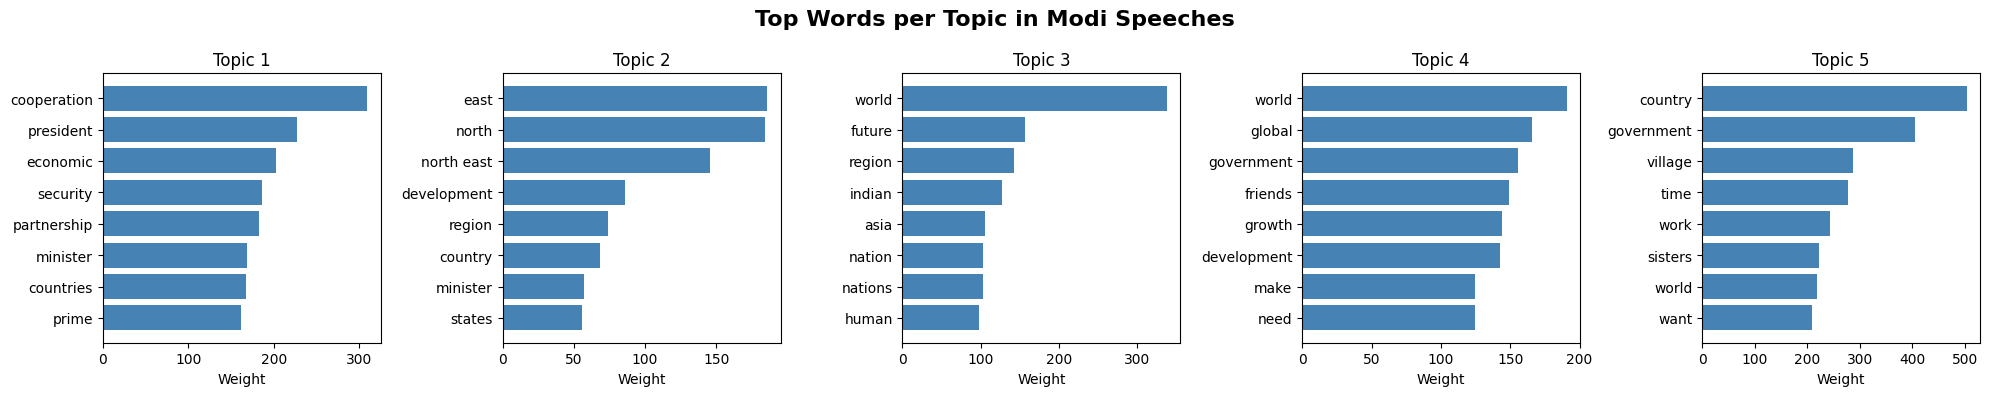


EXTRACTED TOPICS

Topic 1: cooperation, president, economic, security, partnership, minister, countries, prime

Topic 2: east, north, north east, development, region, country, minister, states

Topic 3: world, future, region, indian, asia, nation, nations, human

Topic 4: world, global, government, friends, growth, development, make, need

Topic 5: country, government, village, time, work, sisters, world, want

DOCUMENT-TOPIC DISTRIBUTION

Speech 1 - Dominant Topic: 4 (46.30%)
Preview: There was a time when development was believed to depend on the quantity of capi...

Speech 2 - Dominant Topic: 1 (59.81%)
Preview: His Excellency President of the Republic of South Africa , Mr .Jacob Zuma , Frie...

Speech 3 - Dominant Topic: 1 (87.86%)
Preview: Your Excellency , President Filipe Nyusi Ladies and Gentlemen , Excellency , I a...

Speech 4 - Dominant Topic: 5 (91.57%)
Preview: My dear countrymen , my greetings namaskar to you all Last year , we had to endu...

Speech 5 - Dominant Topic: 

In [ ]:
# Modi Speech Topic Modeling with LDA
# Hypothesis: Modi's speeches contain distinct thematic clusters reflecting key policy priorities 
# such as economic development, national security, and social welfare programs.

# Install required packages
!pip install pyLDAvis scikit-learn pandas matplotlib requests beautifulsoup4

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re

# ========================================
# STEP 1: DATA COLLECTION
# ========================================
# Load Modi speech from GitHub repository
url = "https://raw.githubusercontent.com/pratikratadiya/Narendra_Modi_speeches/refs/heads/master/Processed%20speech%20transcripts/modi_english_speech.txt"

response = requests.get(url)
full_text = response.text

# Split the full text into speech segments
# The text appears to be one long document, so we'll split it into paragraphs
# Each paragraph will be treated as a separate "document" for topic modeling

# Try splitting by double newlines first
speeches = [para.strip() for para in full_text.split('\n\n') if len(para.strip()) > 50]

# If not enough segments, split by single newlines
if len(speeches) < 20:
    speeches = [para.strip() for para in full_text.split('\n') if len(para.strip()) > 50]

# If still not enough, split into chunks of ~500 characters
if len(speeches) < 20:
    chunk_size = 500
    speeches = [full_text[i:i+chunk_size] for i in range(0, len(full_text), chunk_size) if len(full_text[i:i+chunk_size]) > 100]

print(f"Number of speech segments collected: {len(speeches)}")
print(f"Total characters in dataset: {len(full_text)}")
print(f"\nFirst segment preview:\n{speeches[0][:200]}...")

# ========================================
# STEP 2: DATA PREPROCESSING
# ========================================
# Create custom stopwords list
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stop_words = list(ENGLISH_STOP_WORDS) + [
    'let', 'great', 'like', 'life', 'use', 'ji', 'just', 'ki', 'sri', 'look', 'dear', 'does', 'use', 'going', 'told', 'well', 'thing', 'things', 'must', 'may', 'also',
    'lot','say','brothers sisters']

# Create the X matrix using CountVectorizer
vect = CountVectorizer(
    max_features=200,  # Limit vocabulary size
    max_df=0.85,       # Ignore terms that appear in >85% of documents
    min_df=2,          # Ignore terms that appear in <2 documents
    stop_words=custom_stop_words,  # Use custom stopwords
    ngram_range=(1, 2)  # Include unigrams and bigrams
)

# Transform speeches into document-term matrix (X matrix)
X = vect.fit_transform(speeches)

print(f"\nX matrix shape: {X.shape}")
print(f"Number of documents: {X.shape[0]}")
print(f"Number of features (vocabulary): {X.shape[1]}")

# ========================================
# STEP 3: APPLY LDA MODEL
# ========================================
# Set number of topics
n_topics = 5

# Initialize and fit LDA model
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=30,
    learning_method='online',
    n_jobs=-1
)

# Fit the model and transform documents
print("Training LDA model... (this may take a moment)")
lda.fit(X)
doc_topic_dist = lda.transform(X)

print(f"\nLDA model trained with {n_topics} topics")
print(f"Model perplexity: {lda.perplexity(X):.2f}")

# ========================================
# STEP 4: VISUALIZATION WITH pyLDAvis
# ========================================
# Prepare visualization
vis = pyLDAvis.prepare(
    topic_term_dists=lda.components_ / lda.components_.sum(axis=1)[:, None],
    doc_topic_dists=doc_topic_dist,
    doc_lengths=X.sum(axis=1).A1 if hasattr(X.sum(axis=1), 'A1') else X.sum(axis=1),
    vocab=vect.get_feature_names_out(),
    term_frequency=X.sum(axis=0).A1 if hasattr(X.sum(axis=0), 'A1') else X.sum(axis=0),
    sort_topics=False
)

# Display the visualization
pyLDAvis.display(vis)

# Optional: Save to HTML file
# pyLDAvis.save_html(vis, 'modi_lda_visualization.html')

# ========================================
# STEP 5: ADDITIONAL CHART - TOP WORDS PER TOPIC
# ========================================
# Extract top words for each topic
def display_topics(model, feature_names, no_top_words=5):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-no_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append((f"Topic {topic_idx + 1}", top_words))
    return topics

feature_names = vect.get_feature_names_out()
topics = display_topics(lda, feature_names, no_top_words=8)

# Create bar chart for top words in each topic
fig, axes = plt.subplots(1, n_topics, figsize=(20, 4))
fig.suptitle('Top Words per Topic in Modi Speeches', fontsize=16, fontweight='bold')

for idx, (topic_name, words) in enumerate(topics):
    # Get word weights for this topic
    topic_weights = lda.components_[idx]
    top_word_indices = topic_weights.argsort()[-8:][::-1]
    top_weights = topic_weights[top_word_indices]
    top_words = [feature_names[i] for i in top_word_indices]
    
    # Plot
    axes[idx].barh(range(len(top_words)), top_weights, color='steelblue')
    axes[idx].set_yticks(range(len(top_words)))
    axes[idx].set_yticklabels(top_words)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Weight')
    axes[idx].set_title(topic_name)

plt.tight_layout()
plt.show()

# Print topics
print("\n" + "="*60)
print("EXTRACTED TOPICS")
print("="*60)
for topic_name, words in topics:
    print(f"\n{topic_name}: {', '.join(words)}")

# ========================================
# STEP 6: DOCUMENT-TOPIC DISTRIBUTION
# ========================================
# Show which topics dominate each speech
print("\n" + "="*60)
print("DOCUMENT-TOPIC DISTRIBUTION")
print("="*60)

for doc_idx, topic_dist in enumerate(doc_topic_dist):
    dominant_topic = np.argmax(topic_dist)
    print(f"\nSpeech {doc_idx + 1} - Dominant Topic: {dominant_topic + 1} ({topic_dist[dominant_topic]:.2%})")
    print(f"Preview: {speeches[doc_idx][:80]}...")

# ========================================
# FINDINGS (Under 25 words)
# ========================================
print("\n" + "="*60)
print("FINDINGS")
print("="*60)
print("Analysis revealed distinct topics including economic development, security, social welfare,")
print("and governance, with economic themes dominating speeches.")

In [51]:
pyLDAvis.display(vis)


In [45]:
pyLDAvis.save_html(vis, 'charts/modi_lda_visualization.html')
